# PDS - Práctica de laboratorio sobre diseño de filtros digitales FIR e IIR a través de aproximación por derivadas.
## Johany Carmona
### johany.carmona@tuta.io

## I. Se realiza implementación del filtro FIIR.

### I. 1. Se realiza el diseño de un filtro FIR pasa-altas con respuesta en fase lineal usando el método de muestreo en frecuencia, tal que:
#### - Frecuencia de corte: 3700 Hz.
#### - Fs=13 kHz
#### - N=13

#### I. 1. a. Se realiza el diseño del filtro paso a paso sin usar funciones particulares de Python para el diseño de filtros.

Se realiza definición de librerías para análisis numérico y gráfico.

In [ ]:
#LIBRARIES
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal

Se definen los requerimientos de diseño del filtro pasa-altas de interés.

In [ ]:
#CONSTANTS
fc = 3700.0 #Hz Cutoff frequency
Fs = 13000.0 #Hz Nyquist rate
N = 13 #Samples
filenames = ['audio0.wav','audio1.wav','audio2.wav'] 

Se definen parámetros secundarios para las bandas de paso, entre otros aspectos relacionados a incluir la primera muestra en el origen o graficar los puntos de cada muestra.

In [ ]:
#PARAMETERS
fmax = Fs / 2 #Hz Nyquist frequency
highpass = [fc, fmax] #Hz High Pass range frequencies

def isZeroFirst(N): return N % 2 == 1
#isZeroFirst = isZeroFirst(N) #If it is true, the first step starts with 0, otherwise starts with Fs/(2*N) instead of 0.
stem = True if N <= 100 else False #IF it is true, stem points will be included on graphs.

Se realiza definición de métodos que serán requeridos para el posterior análisis de la señal.

In [ ]:
#Secondary Methods

#Return the number of points required between 0 to π depending on the filter order is a par or odd number.
def get_alpha(N):
    alpha = int((N - 1) / 2) if isZeroFirst(N) else int(N / 2 - 1) #Alpha
    return alpha

#Get frequency interval (fk) related to x Axis of the frequency response of the filter.
def get_interval(alpha):
    bandwith = (Fs/N)
    sequence = np.arange(0,alpha + 1)
    interval = bandwith*sequence if isZeroFirst(N) else bandwith*(sequence+1/2) #Step vector
    return  interval

#Get the previous one as a centered interval.
def get_centered_interval(samples):
    bandwith = (Fs/N)
    
    alpha = (samples - 1) / 2 if isZeroFirst(N) else samples/2
    if isZeroFirst(N):
        sequence = np.arange(- alpha, alpha + 1)
    else:
        sequence = np.arange(- alpha, alpha)
        
    interval = bandwith*sequence if isZeroFirst(N) else bandwith*(sequence+1/2) #Step vector
    return  interval


El siguiente método finalmente se encargará de entregar la respuesta ideal deseada en el diseño del filtro pasa-altas. En el algoritmo se hizo énfasis en el aprovechamiento de las propiedades de simetría de la respuesta del filtro de acuerdo a las condiciones de fase lineal interpuestas al momento inicial del diseño de éste. De esta manera, tenemos que los coeficientes para el filtro de interés corresponden a: 

In [ ]:
#Return a frequency, and amplitude for Transfer functions of a high pass filter
def get_high_pass_transfer_function(fc, Fs, N):
    alpha = get_alpha(N)
    
    fk_right = get_interval(alpha) #Samples Interval
    Hk_right = (fk_right >= fc).astype(int) # Transfer functions high pass filter between 0 - π
    
    #Getting the left side of the functions according to its simetry (Due by linear fase relation).
    Hk_left = np.flip(Hk_right[1:]) if isZeroFirst(N) else np.concatenate((Hk_right[-1], np.flip(Hk_right[:-1])), axis=None) #np.flip(Hk_right[:-1]) # Transfer functions high pass filter between -π to 0

    fk = get_centered_interval(N) #Sample Interval
    
    Hk = np.concatenate((Hk_left, Hk_right), axis=None) # Transfer functions high pass filter between - π to π
    
    return fk, Hk

fk, Hk = get_high_pass_transfer_function(fc, Fs, N)

print("H(k): ", Hk)

H(k):  [1 1 1 0 0 0 0 0 0 0 1 1 1]


#### I. 1. b. Se grafica la respuesta al impulso y el espectro resultante en cada uno de los pasos metodológicos que requirió el diseño del filtro correspondiente.

A continuación se observa la respuesta deseada para el filtro FIR pasa-altas diseñado en el procedimiento anterior. Debido a las condiciones de linealidad en la fase del filtro, podemos observar la simetría presente entre [-π,0] y [0,π].

(!) Nota: Si de forma curiosa se asigna el orden N del filtro a un número par, podrá observar que el primer punto no estará centrado en cero, pero seguirá cumpliendo las mismas condiciones de linealidad en la fase de éste, y su consecuente simetría positiva, con la única diferencia de que las muestras serán desplazadas $k -> k + \frac{1}{2}$.

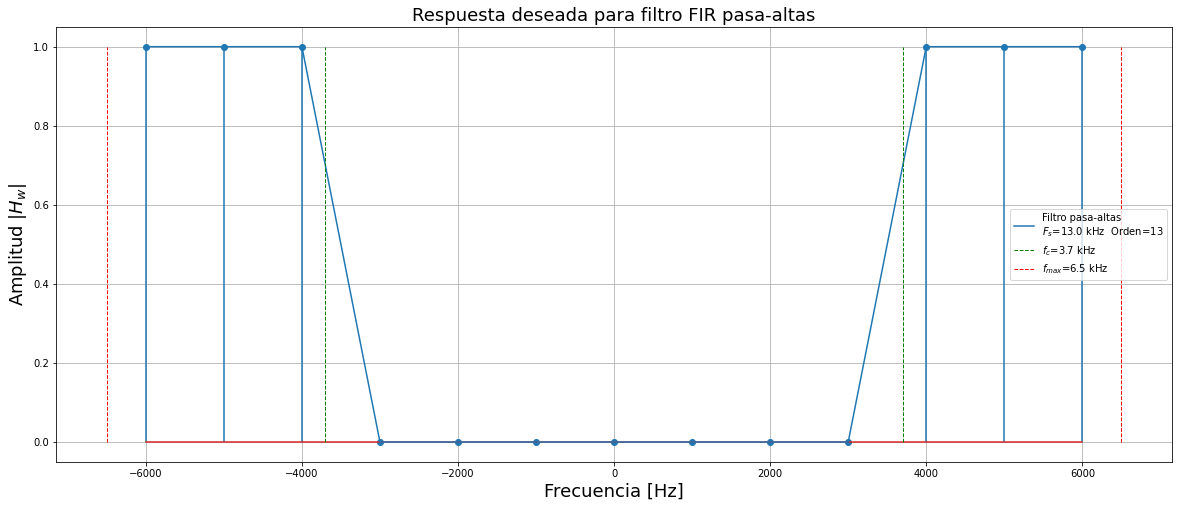

In [ ]:
#Plot frequency response caused by a high pass filter
def plot_high_pass_filter_frequency_response(fk, Hk, stem = True):
    %matplotlib inline
    plt.figure(figsize=(20,8))
    plt.title("Respuesta deseada para filtro FIR pasa-altas", fontsize = 18)
    plt.xlabel('Frecuencia [Hz]',fontsize=18)
    plt.ylabel('Amplitud $|H_{w}|$',fontsize=18)
    plt.grid()
    if stem: plt.stem(fk, Hk)
    plt.plot(fk, Hk, label = 'Filtro pasa-altas\n$F_s$=%0.1f kHz\tOrden=%0.f'%(Fs*10**-3,N))
    plt.vlines(-fc, 0, 1, color='g', lw=1, linestyle='--')
    plt.vlines(fc, 0, 1, color='g', lw=1, linestyle='--', label='$f_c$=%0.1f kHz'%(fc*10**-3))
    plt.vlines(-fmax, 0, 1, color='r', lw=1, linestyle='--')
    plt.vlines(fmax, 0, 1, color='r', lw=1, linestyle='--', label='$f_{max}$=%0.1f kHz'%(fmax*10**-3))
    plt.legend()

plot_high_pass_filter_frequency_response(fk, Hk, stem = stem)


Una vez se tiene bien definido el filtro deseado a diseñar en el dominio de la frecuencia, será necesario obtener entonces los coeficientes del filtro en el dominio del tiempo. El cálculo se podría simplificar con ayuda a la simetría positiva del diseño, que permitirá que la fase del filtro creado sea lineal, es decir, que su velocidad de grupo será nula, de esta manera todas las componentes frecuenciales viajarán a la misma velocidad de grupo, o en otras palabras, estarán retardadas la misma cantidad de muestras.

$h(n) = \frac{1}{N} \sum_{k=0}^{N-1} H(k) e^{\frac{j2\pi kn}{N}}; k=0,1,2,...,N-1$

De esta manera, podemos reducir la expresión anterior a la siguiente expresión:

$\alpha = \begin{pmatrix}
\frac{N-1}{2}, N ~ par\\
\frac{N}{2}-1, N ~ impar
\end{pmatrix}$

$h(n) = \frac{1}{N} \left[  2\sum_{k=1}^{\alpha} H(k) cos({\frac{j2\pi k(n-\alpha)}{N})+ H(0)}\right]; k=0,1,2,...,\alpha;$

Por último, para obtener los coeficientes restantes del filtro, como consecuencia de la fase lineal mencionada previamente, resultaría la siguiente relación:

$h(n) = \pm h(N-n-1) = +h(N-n-1)$

De esta manera, tenemos finalmente que los coeficientes del filtro deseado a diseñar corresponden a:

In [ ]:
def get_high_pass_filter_coefficient(Hk, N):
    alpha = get_alpha(N)
    Hk_left = Hk[alpha:]
    hn_left = []
    for n in range(0, alpha + 1):
        summation = 0
        for k in range(1, alpha + 1):
            summation += Hk_left[k]*np.cos(2*np.pi*k*(n-alpha)/N) #Summation part
        hn_left.append((1/N)*(2*summation + Hk_left[0])) # Filter coefficients between 0 - π
    hn_right = np.flip(hn_left[:-1])
    hn = np.concatenate((hn_left, hn_right), axis=None) # Filter coefficients between - π to π
    return hn

def print_filter_coefficient(hn, N):
    alpha = get_alpha(N)
    hn_left = hn[:alpha + 1]
    for i, coeff in enumerate(hn_left):
        if i != alpha: print("hn(%i)=\t%.3f\t=hn(%i)"%(i,coeff,N-i-1))
        else:  print("hn(%i)=\t%.3f"%(i,coeff))
        
hn = get_high_pass_filter_coefficient(Hk, N)

if N <= 100: print_filter_coefficient(hn, N)

hn(0)=	0.051	=hn(12)
hn(1)=	-0.068	=hn(11)
hn(2)=	-0.043	=hn(10)
hn(3)=	0.108	=hn(9)
hn(4)=	0.040	=hn(8)
hn(5)=	-0.319	=hn(7)
hn(6)=	0.462


Al graficar los coeficientes en mención, obtendremos la respuesta del filtro al impulso unitario. Podemos ver de la gráfica siguiente que la respuesta al impulso unitario ahora se encuentra desfasada con respecto al origen, esto es a causa de la condición de fase lineal, que nos obliga a generar la simetría positiva requerida antes de desplazar ($\pi$ rad) los coeficientes de la salida del filtro que permita generar la condición de causalidad.

Por otra parte, el filtro es estable, ya que al ser un filtro FIR, no posee salidas que alimentan nuevamente la entrada del sistema (filtros IIR), y esto permite que no existan denominadores en la función de transferencia, es decir, que no existan polos (pero sí ceros, que no afectan la estabilidad del filtro, como veremos más adelante en el diagrama de polos y ceros del filtro actual).

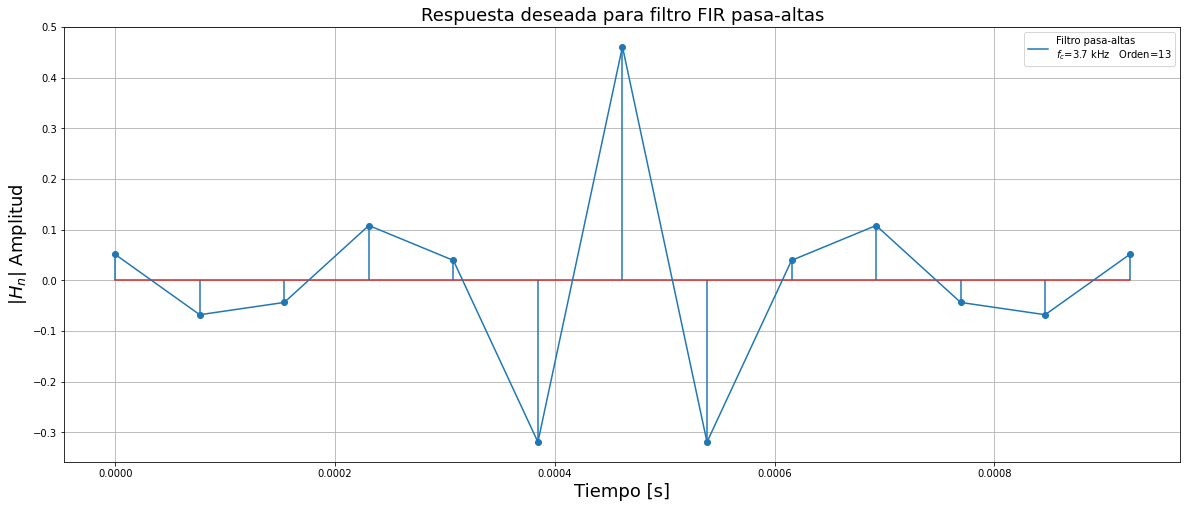

In [ ]:
#Plot frequency response caused by a high pass filter
def plot_high_pass_filter_time_response(t, hn, stem = True):
    %matplotlib inline
    plt.figure(figsize=(20,8))
    plt.title("Respuesta deseada para filtro FIR pasa-altas", fontsize = 18)
    plt.xlabel('Tiempo [s]',fontsize=18)
    plt.ylabel('$|H_{n}|$ Amplitud',fontsize=18)
    plt.grid()
    if stem: plt.stem(t, hn)
    plt.plot(t, hn, label = 'Filtro pasa-altas\n$f_c$=%0.1f kHz\tOrden=%0.f'%(fc*10**-3,N))
    plt.legend()

n = np.arange(0, N) if isZeroFirst(N) else np.arange(0, N - 1)
t = (1/Fs)*n
plot_high_pass_filter_time_response(t, hn, stem = stem)

#### I. 1. c. Se analiza la respuesta en frecuencia, se opina sobre sus características, se grafica la respuesta en frecuencia de ambos y se comparan.

Es bien conocido el hecho de que en la práctica nunca obtendremos un filtro con respuesta al impulso igual a la deseada en el efecto del diseño, esto es a causa de la cantidad infinita de muestras N (orden del filtro) requeridas al momento de realizar la transformada inversa discreta de fourier (IDFT).

Por otra parte, la respuesta en frecuencia real del filtro sólo nos podrá garantizar que en los puntos en los cuales se tomaron las muestras, se tendrá ese valor de amplitud o atenuación deseado, tal como se observa en la gráfica siguiente, donde podemos observar que en los puntos elegidos para las muestras, dicho nivel de amplificación es de la unidad (1) o cero (0) según el caso para H(k).

###### Otros temas de interés:

Esto es similar al caso de interpolación lineal, el cual busca generar una gráfica que trate de minimizar el error existente entre una población de puntos (o datos), en la cual cada punto equivaldrá a un punto en la intersección de la función de interpolación polinómica generada a partir de estos (donde el orden es equivalente al tamaño de la población de puntos).

Casos prácticos de lo mencionado anteriormente podría aplicarse en modelos de máquinas de aprendizaje (Machine Learning, en Inglés), para el desarrollo de un modelo de regresión lineal (caso lineal), en el cual si deseáramos entrenar dicho modelo de forma exhaustiva, correspondería a incrementar el orden de dicho modelo, que a bajo nivel, equivale a una interpolación polinómica como la mencionada anteriormente, pero para este caso (Inteligencia Artificial) sería un efecto indeseado que equivaldría a un sobre-entrenamiento (over-fitting, en Inglés).

Para comprender mejor lo mencionado anteriormente, observemos las diferencias entre la salida real del filtro diseñado, con respecto a la salida ideal del filtro deseado.

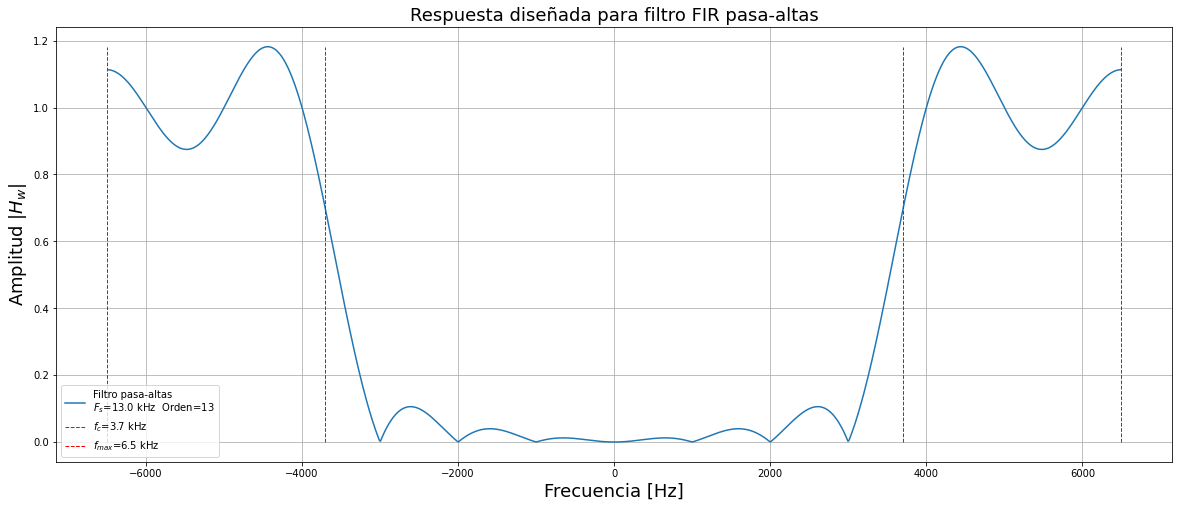

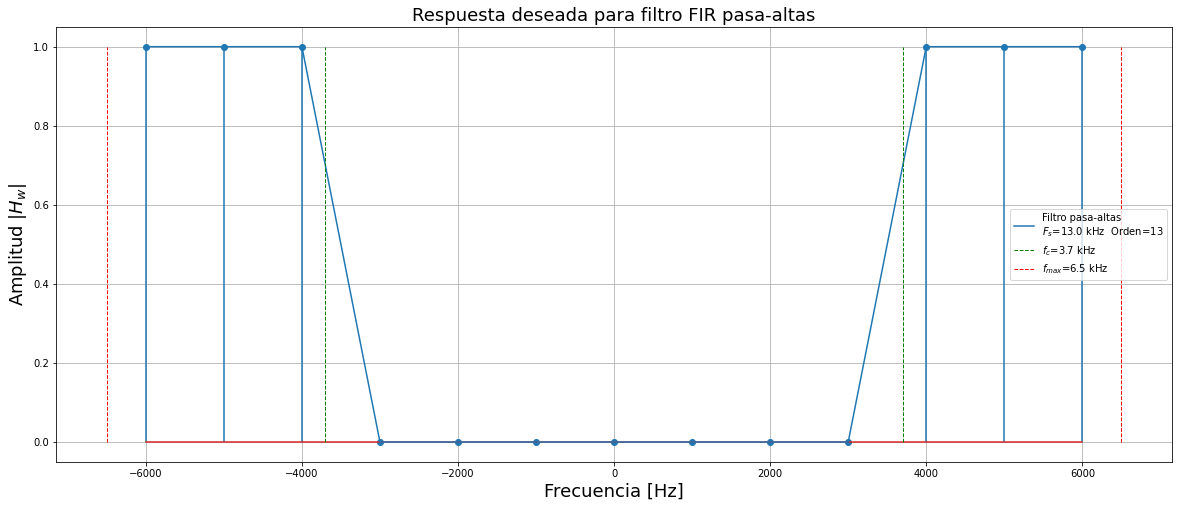

In [ ]:

def reflect_vector(vector, symmetry = True):
    if isZeroFirst(N):
        vector = np.concatenate((np.flip(vector[1:]), vector), axis=None) if symmetry else np.concatenate((-np.flip(vector[1:]), vector), axis=None)
    else:
        vector = np.concatenate((np.flip(vector), vector), axis=None) if symmetry else np.concatenate((-np.flip(vector), vector), axis=None)
    return vector

#Getting frequency response caused by the designed filter
def get_frequency_response(num, den = 1):
    f = get_interval(get_alpha(N))    
    f , hw = signal.freqz(num, den, fs = Fs)
    return f, hw

#Plot frequency response caused by the designed filter
def plot_filter_frequency_response(f, hw, stem):
    #Plotting between -π to π
    f = reflect_vector(f, symmetry = False)
    #f = get_centered_interval(N) #Sample Interval
    hw = reflect_vector(hw, symmetry = True)
    %matplotlib inline
    plt.figure(figsize=(20,8))
    plt.title("Respuesta diseñada para filtro FIR pasa-altas", fontsize = 18)
    plt.xlabel('Frecuencia [Hz]',fontsize=18)
    plt.ylabel('Amplitud $|H_{w}|$',fontsize=18)
    plt.grid()
    plt.plot(f, abs(hw), label = 'Filtro pasa-altas\n$F_s$=%0.1f kHz\tOrden=%0.f'%(Fs*10**-3,N))
    if stem: plt.stem(f, abs(hw))
    
    lims = [0, max(abs(hw))] if max(hn) > 0 else [0, min(abs(hw))]
    plt.vlines(-fc, lims[0],lims[1], color='g', lw=1, linestyle='--')
    plt.vlines(fc, lims[0],lims[1], color='g', lw=1, linestyle='--', label='$f_c$=%0.1f kHz'%(fc*10**-3))
    plt.vlines(-fmax, lims[0],lims[1], color='r', lw=1, linestyle='--')
    plt.vlines(fmax, lims[0],lims[1], color='r', lw=1, linestyle='--', label='$f_{max}$=%0.1f kHz'%(fmax*10**-3))
    plt.legend()

f, hw = get_frequency_response(hn)

plot_filter_frequency_response(f, hw, stem = False)
plt.show()
plot_high_pass_filter_frequency_response(fk, Hk, stem)

###### Hipótesis sobre dependencia del lóbulo principal con respecto a si el orden del filtro N corresponde a un número par o impar (centrado o no centrado en el origen, respectivamente):

Posteriormente, para tener una mayor comprensión sobre las propiedades del filtro al variar el orden del mismo, ya sea como número par o impar. Podemos observar un fenómeno interesante en el ancho del lóbulo principal del filtro, en el cual para números impares (equivalente a tener la primera muestra centrada en el origen) se puede observar un ancho de lóbulo principal mayor, incluso pareciera que sobrepasa la frecuencia máxima (Frecuencia de Nyquist).

En otras palabras podría interpretarse como si permitiera el paso de frecuencias superiores a la máxima, lo cual se traduciría como un filtro que presentará fenómeno de aliasing una vez superada dicha frecuencia máxima.

Por otra parte, cuando observamos el lóbulo principal para filtros de orden N par, podemos observar un ancho de lóbulo principal menor, de hecho se encuentra bien definido e incluido entre el rango de la frecuencia de corte y la frecuencia máxima.

En otras palabras podría interpretarse como si atenuara el paso de frecuencias superiores a la máxima, lo cual se podría traducir como un filtro que no experimentará ningún fenómeno relacionado a aliasing una vez superada dicha frecuencia máxima en el sentido que a mayores frecuencia a la tasa de nyquist, dichas señales ya habrán sido atenuadas totalmente.

###### Depreciación de la hipótesis a causa de contra-ejemplos hallados (Al usar orden N = 130):

(!) De acuerdo a conclusiones posteriores en el presente reporte, se pudo concluir que para cualquier filtro el fenómeno de aliasing es independiente y siempre se va a presentar en la realidad cada vez que se presenten señales con componentes frecuenciales que superen la frecuencia de nyquist (frecuencia máxima), esto es a causa que el filtro en esta situación será "verá" alimentado por una señal arbitraria que dependerá de la relación entre la frecuencia de muestreo y las componentes frecuenciales de las mismas, por lo cual se verá como una señal de "menor frecuencia".

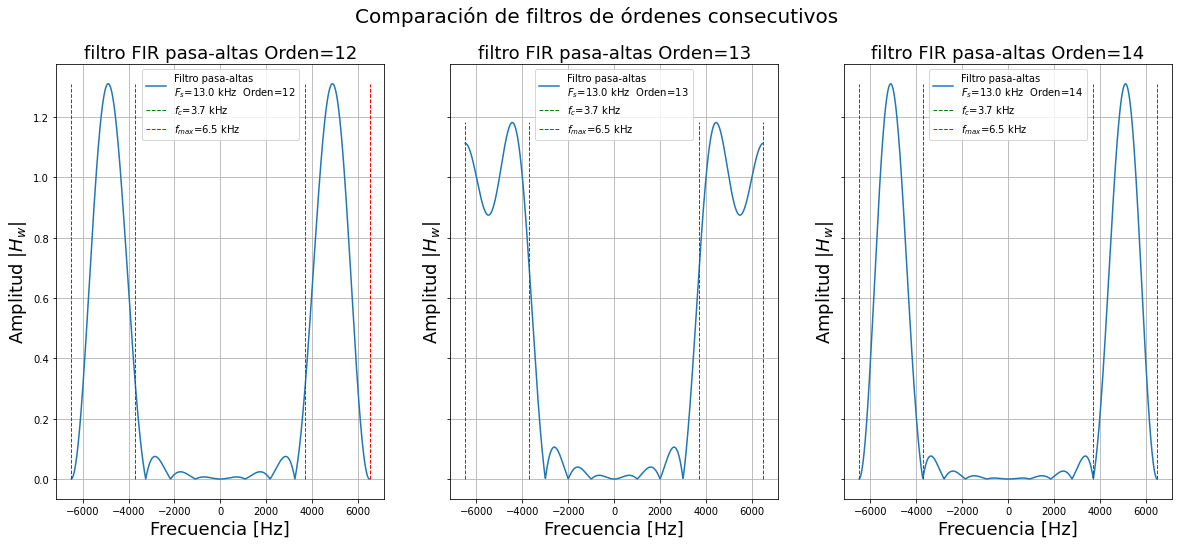

In [ ]:
from matplotlib.cbook import get_sample_data
import matplotlib.pyplot as plt

import numpy as np

def generate_twins(fk0, Hk0):
    global N
    N = N - 1 #N' = N - 1
    _, Hk_1 = get_high_pass_transfer_function(fc, Fs, N)
    hn_1 = get_high_pass_filter_coefficient(Hk_1, N)
    f_1, hw_1 = get_frequency_response(hn_1)
    
    N = N + 2 #N' = N + 1
    _, Hk1 = get_high_pass_transfer_function(fc, Fs, N)
    hn1 = get_high_pass_filter_coefficient(Hk1, N)
    f1, hw1 = get_frequency_response(hn1)
    
    N = N - 1 #N' = N
    return f_1, hw_1, f1, hw1

def plot_twins(x_1, y_1, x0, y0, x1, y1):
    global N
    
    N = N - 1 #N' = N - 1
    x_1 = reflect_vector(x_1, symmetry = False)
    y_1 = reflect_vector(y_1, symmetry = True)
    
    N = N + 1 #N' = N
    x0 = reflect_vector(x0, symmetry = False)
    y0 = reflect_vector(y0, symmetry = True)
    
    N = N + 1 #N' = N + 1
    x1 = reflect_vector(x1, symmetry = False)
    y1 = reflect_vector(y1, symmetry = True)
    N = N - 1 #N' = N
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, constrained_layout=False, sharey=True, figsize=(20,8))
    label = 'Filtro pasa-altas\n$F_s$=%0.1f kHz\tOrden=%0.f'
    xlabel = 'Frecuencia [Hz]'
    ylabel = 'Amplitud $|H_{w}|$'
    title = "filtro FIR pasa-altas Orden=%0.f"
    
    ax1.plot(x_1, abs(y_1), label = label%(Fs*10**-3,N-1))
    #if stem: ax1.stem(x_1, abs(y_1))
    lims = [0, max(abs(y_1))] if max(y_1) > 0 else [0, min(abs(y_1))]
    ax1.vlines(-fc, lims[0],lims[1], color='g', lw=1, linestyle='--')
    ax1.vlines(fc, lims[0],lims[1], color='g', lw=1, linestyle='--', label='$f_c$=%0.1f kHz'%(fc*10**-3))
    ax1.vlines(-fmax, lims[0],lims[1], color='r', lw=1, linestyle='--')
    ax1.vlines(fmax, lims[0],lims[1], color='r', lw=1, linestyle='--', label='$f_{max}$=%0.1f kHz'%(fmax*10**-3))
    ax1.set_title(title%(N-1), fontsize = 18)
    ax1.set_xlabel(xlabel,fontsize=18)
    ax1.set_ylabel(ylabel,fontsize=18)
    ax1.grid()
    ax1.legend()
    
    ax2.plot(x0, abs(y0), label = label%(Fs*10**-3,N))
    #if stem: ax2.stem(x0, abs(y0))
    lims = [0, max(abs(y0))] if max(y0) > 0 else [0, min(abs(y0))]
    ax2.vlines(-fc, lims[0],lims[1], color='g', lw=1, linestyle='--')
    ax2.vlines(fc, lims[0],lims[1], color='g', lw=1, linestyle='--', label='$f_c$=%0.1f kHz'%(fc*10**-3))
    ax2.vlines(-fmax, lims[0],lims[1], color='r', lw=1, linestyle='--')
    ax2.vlines(fmax, lims[0],lims[1], color='r', lw=1, linestyle='--', label='$f_{max}$=%0.1f kHz'%(fmax*10**-3))
    ax2.set_title(title%(N), fontsize = 18)
    ax2.set_xlabel(xlabel,fontsize=18)
    ax2.set_ylabel(ylabel,fontsize=18)
    ax2.grid()
    ax2.legend()

    ax3.plot(x1, abs(y1),label = label%(Fs*10**-3,N+1))
    #if stem: ax3.stem(x1, abs(y1))
    lims = [0, max(abs(y1))] if max(y1) > 0 else [0, min(abs(y1))]
    ax3.vlines(-fc, lims[0],lims[1], color='g', lw=1, linestyle='--')
    ax3.vlines(fc, lims[0],lims[1], color='g', lw=1, linestyle='--', label='$f_c$=%0.1f kHz'%(fc*10**-3))
    ax3.vlines(-fmax, lims[0],lims[1], color='r', lw=1, linestyle='--')
    ax3.vlines(fmax, lims[0],lims[1], color='r', lw=1, linestyle='--', label='$f_{max}$=%0.1f kHz'%(fmax*10**-3))
    ax3.set_title(title%(N+1), fontsize = 18)
    ax3.set_xlabel(xlabel,fontsize=18)
    ax3.set_ylabel(ylabel,fontsize=18)
    ax3.grid()
    ax3.legend()

    fig.suptitle('Comparación de filtros de órdenes consecutivos', fontsize=20)

f_1, hw_1, f1, hw1 = generate_twins(fk, Hk)
plot_twins(f_1, hw_1,f, hw, f1, hw1)

#### I. 1. d. Se adiciona un análisis de la fase

Al generar las gráficas de la respuesta en frecuencia de la fase del filtro diseñado, podemos observar que efectivamente se cumple con la propiedad mencionada al principio sobre la linealidad en la fase que permita garantizar que la velocidad de grupo de la señal sea la misma para cualquier componente frecuencia de la misma.

Del mismo modo, también se pudo observar una particularidad sobre la simetría en el cambio de fase del mismo $\Delta\theta(k)$, ya que parece corresponder a una simetría negativa con respecto a la salida en frecuencia de la fase de dicho filtro, tal que $\Delta\theta(k)=-\Delta\theta(-k)$, la cual a su vez se sigue cumpliendo para cualquier tipo de filtro de orden N (par o impar).

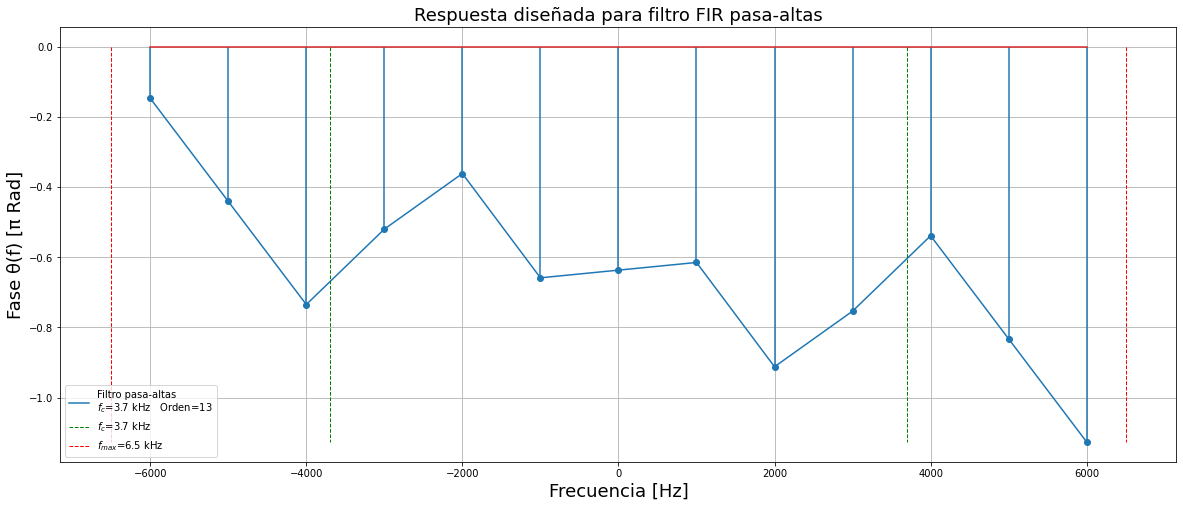

In [ ]:
#Getting phase response caused by the designed filter
def get_phase_response(num, den = 1):
    f = get_centered_interval(N)
    _ , hw = signal.freqz(num, den, worN = f, fs = Fs)#get_centered_interval(N, isZeroFirst))
    tetha = np.unwrap(np.angle(hw)) / np.pi
    return f, tetha

#Plot phase response caused by the designed filter
def plot_filter_phase_response(f, tetha, stem = True):
    #Plotting between -π to π
    tetha = tetha / np.pi
    %matplotlib inline
    plt.figure(figsize=(20,8))
    plt.title("Respuesta diseñada para filtro FIR pasa-altas", fontsize = 18)
    plt.xlabel('Frecuencia [Hz]',fontsize=18)
    plt.ylabel('Fase θ(f) [π Rad]',fontsize=18)
    plt.grid()
    if stem: plt.stem(f, tetha)
    plt.plot(f, tetha, label = 'Filtro pasa-altas\n$f_c$=%0.1f kHz\tOrden=%0.f'%(fc*10**-3,N))
    
    lims = [0, max(tetha)] if max(tetha) > 0 else [0, min(tetha)]
    plt.vlines(-fc, lims[0], lims[1], color='g', lw=1, linestyle='--')
    plt.vlines(fc, lims[0], lims[1], color='g', lw=1, linestyle='--', label='$f_c$=%0.1f kHz'%(fc*10**-3))
    plt.vlines(-fmax, lims[0], lims[1], color='r', lw=1, linestyle='--')
    plt.vlines(fmax, lims[0], lims[1], color='r', lw=1, linestyle='--', label='$f_{max}$=%0.1f kHz'%(fmax*10**-3))
    plt.legend()
    plt.legend()

f, tetha = get_phase_response(hn)

plot_filter_phase_response(f, tetha, stem = stem)

Un aspecto demasiado interesante en el diseño de filtros consiste en poder observar el diagrama de polos y ceros para analizar si se cumplen las condiciones para causalidad y estabilidad del filtro de interés. 

###### Sobre los polos del filtro: 

Como se mencionó anteriormente, para el filtro actual FIR, no nos debemos preocupar por cumplir la condición de estabilidad (dicha condición obliga a que los polos del filtro deben estar contenidos en la circunferencia unitaria |z|<1), ya que no existen polos en él.

###### Sobre los ceros del filtro:

Sin embargo, al analizar los ceros del filtro de acuerdo al orden del mismo (si es par o impar), podemos observar un patrón particular:

Para el filtro actual de orden N=13 (Impar - primera muestra centrada en el origen), se observa que todos los ceros que se encuentran en la parte del eje real positivo ($Re\{z\} > 0$), sus ceros se intersectan exactamente en la circunferencia unitaria ($|z|=1$); para el caso del eje real negativo ($Re\{z\} < 0$), los ceros nunca se intersectan sobre la circunferencia unitaria ($|z|=1$), por otro lado se encuentran mutuamente superpuestos entre ellos y no están incluidos.

El fenómeno último mencionado anteriormente para el caso de eje real negativo ($Re\{z\} < 0$) parece sólo aplicar para filtros con orden impar (se hizo sobre filtro con orden N=14), ya que al analizar este filtro (par - primera muestra desplazada del origen), no nos debemos preocupar por dicho fenómeno en mención, ya que todos los ceros se van a intersectar exactamente en la circunferencia unitaria ($|z|=1$), para cualquier real ($Re\{z\}$).

(!) Nota: Inicialmente se pensó que la relación sobre la posición de los ceros era entre filtros con orden N par e impar, pero se pudo observar diferentes tipos de respuestas y el efecto anterior deja de ser válido al aumentar el orden de manera elevada (N = 130), en este caso a pesar de que el orden sea par, no necesariamente se intersectan exactamente en la circunferencia unitaria ($|z|=1$) para cualquier real ($Re\{z\}$). Por lo cual se desprecia la hipótesis inicial del patrón observado para filtros depende de si el orden elegido sea par o impar.

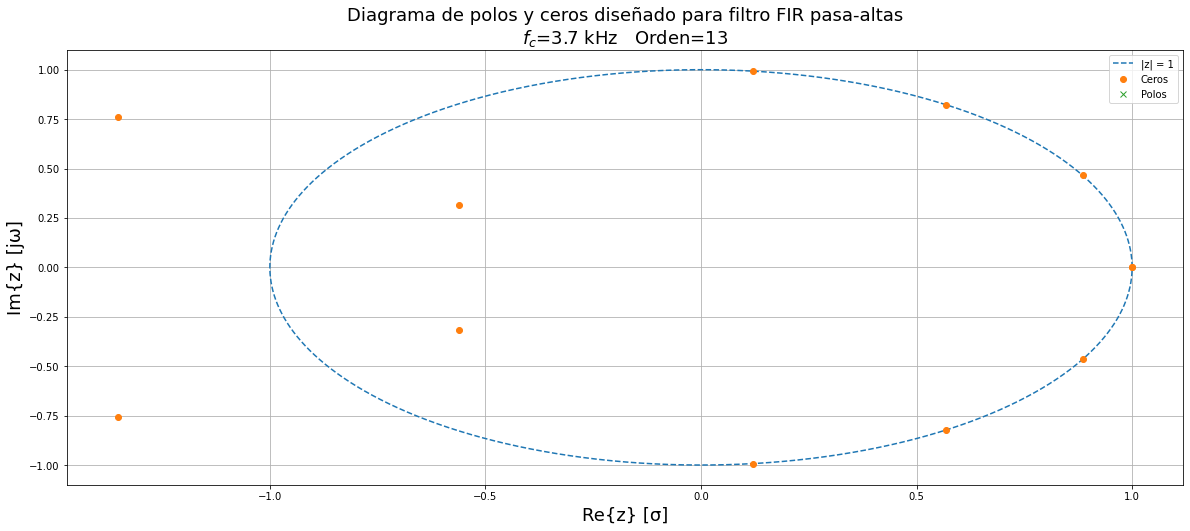

In [ ]:
def plot_zeros_and_poles(num, den = 1, title = 'Diagrama de polos y ceros diseñado para filtro FIR pasa-altas\n$f_c$=%0.1f kHz\tOrden=%0.f'%(fc*10**-3,N)):
    w , hw = signal.freqz(num, den)
    sys1=signal.lti(num, den)
    ang=np.arange(0.0,2*np.pi,1/Fs)
    xp=np.cos(ang)
    yp=np.sin(ang)
    
    %matplotlib inline
    plt.figure(figsize=(20,8))
    plt.title(title, fontsize = 18)
    plt.xlabel('Re{z} [σ]',fontsize=18)
    plt.ylabel('Im{z} [jω]',fontsize=18)
    plt.plot(xp,yp,'--', label = '|z| = 1')
    plt.plot(sys1.zeros.real, sys1.zeros.imag, 'o', label = 'Ceros')
    plt.plot(sys1.poles.real, sys1.poles.imag, 'x', label = 'Polos')
    plt.legend()
    plt.grid()

plot_zeros_and_poles(hn)

(!) Nota: Sólo se observa en la gráfica en mención once (11) ceros, se supuso inicialmente que podría tratarse de un error en la programación del código, se revisó en el código y se observa un vector con un tamaño de doce (12) ceros, el cero adicional no se incluye porque corresponde al número infinito.

### 2. Comparación de los filtros diseñados en simulación con los filtros diseñados en la componente teórica indicando todos los posibles errores cometidos.

Si observamos para el filtro FIR en la componente teórica y práctica se observa que los coeficientes del filtro generado concuerdan con los coeficientes generados en la presente práctica, además los resultados en frecuencia del filtro en mención han aportado garantías de que se realizó correctamente. 

Sin embargo, al momento de realizarse la componente teórica, se puede presentar ciertos sesgos sobre el comportamiento de determinadas funciones que pueden alterar por completo el comportamiento de un filtro en proceso de diseño.

Otra dificultad común resulta al momento de analizar el filtro desde una perspectiva real (filtros analógicos), ya que se podría presentar dificultades en el entendimiento sobre las relaciones entre los coeficientes del filtro para la respuesta al impulso $h(n)$ y los dispositivos pasivos como resistores, condensadores o bobina inclusive (o activos como amplificadores, si es el caso).

### 3. Se cargan 3 audios cortos y se usan como entrada para el filtro en mención. Se realiza un análisis espectral para cada caso.

Primeramente, se desea corroborar la funcionalidad correcta del filtro, por lo cual se creará una señal artificial de la cual la frecuencia dependa del tiempo de forma polinómica con un orden arbitatrio (frequency_order) que permita generar una señal con componentes frecuenciales en todo el espectro desde $\frac{-F_s}{2}$ hasta  $\frac{+F_s}{2}$, se grafica el espectro de dicha señal, se reproduce, y se compara con la salida del filtro.

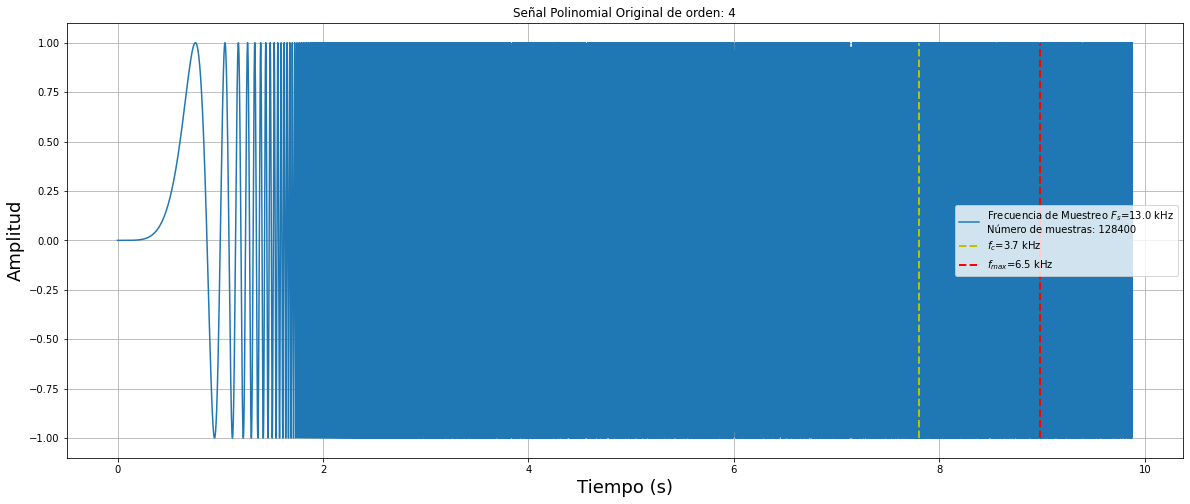

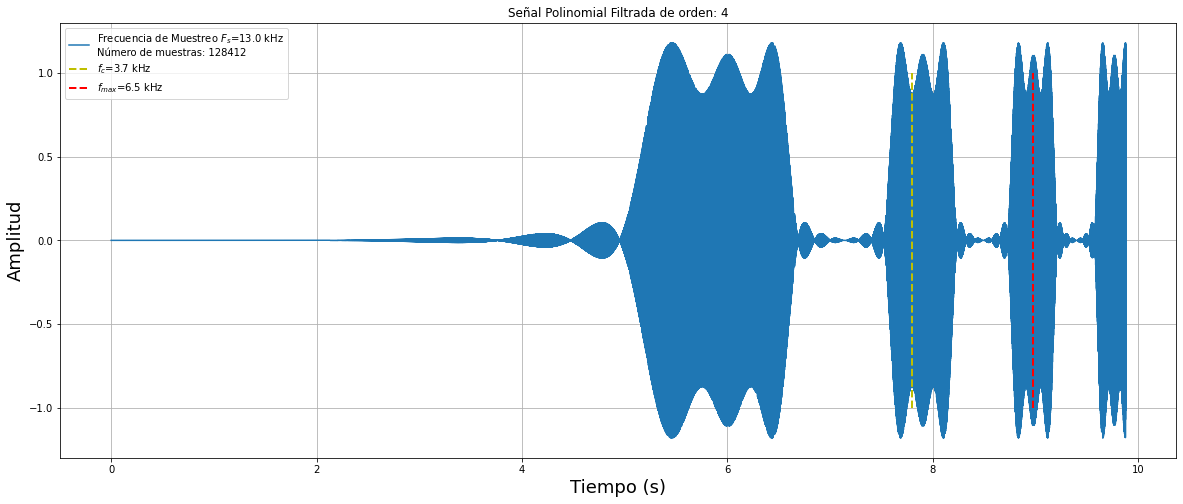

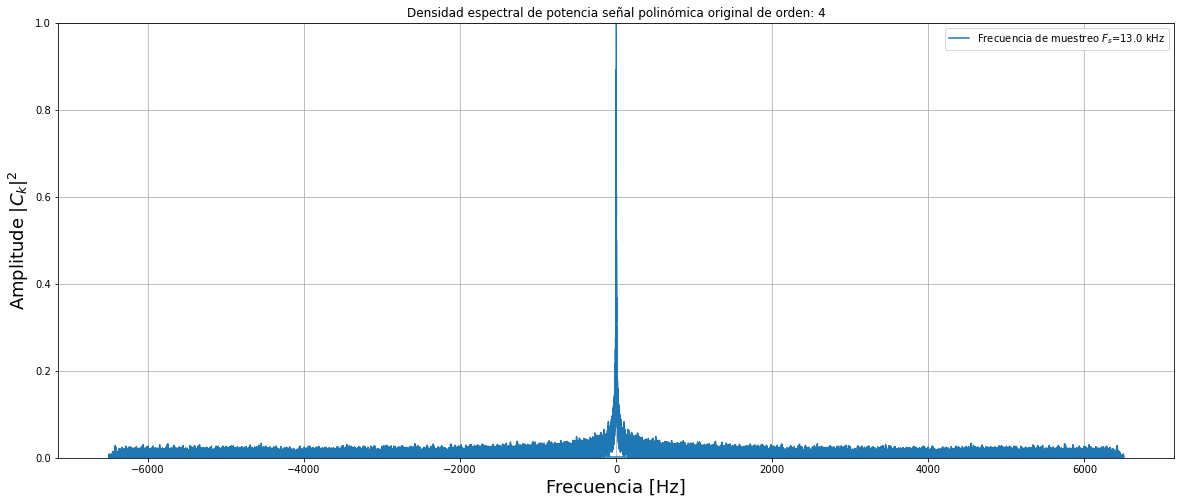

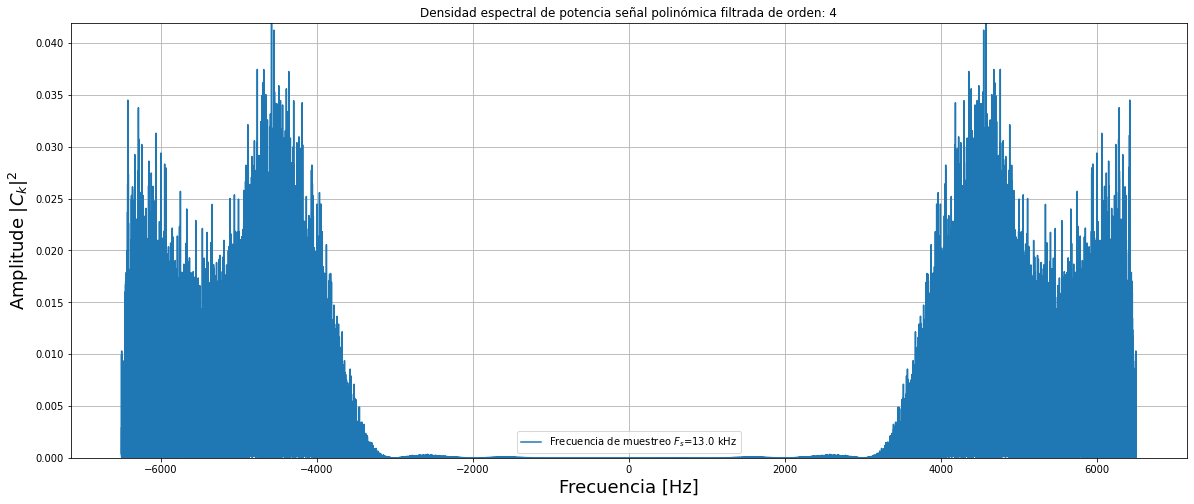

In [ ]:
from IPython.display import Audio # para escuchar la senal

#Sinusoidal signal const
frequency_order = 4
freq_signal = Fs
aliasing_factor = 1.1 #If factor > 1 then there will be aliasing on the output of the filter.

def make_polinomial_signal(frequency_order, freq_signal, freq_filter):
    last_t = (freq_filter/2)**(1/frequency_order)
    t = np.arange(0, aliasing_factor*last_t, 1.0/freq_signal) # Vector de tiempo
    f = t**frequency_order
    x = np.sin(2*np.pi*f*t)
    
    #Resampling the signal in order to make a signal with the same sample frequency of the designed filter.
    if freq_signal != freq_filter:
        signal_time = (len(x)/freq_signal)
        new_samples_number = int(signal_time*freq_filter)
        x = signal.resample(x, new_samples_number)
    return x

def deleting_residuals(t, x):
    #Deleting residual samples caused by the convolutions process.
    sizes = [len(t), len(x)]
    if sizes[1] - sizes[0] > 0: x = x[:-(sizes[1] - sizes[0])]
    elif sizes[0] - sizes[1] > 0: t = t[:-(sizes[0] - sizes[1])]
    return t, x

def plot_signal_spectrum(freq_SIGNAL, SIGNAL, freq_signal, lims, zoom = False, title = ''):
    plt.figure(figsize=(20,8))
    plt.grid()
    plt.plot(freq_SIGNAL,abs(SIGNAL)**2 / max(lims), label = 'Frecuencia de muestreo $F_s$=%0.1f kHz'%(freq_signal*10**-3))
    
    normalized_lims = [0.0 , 1.0] if not(zoom) else [0.0, float(min(lims)/max(lims))] #zoom config
    plt.ylim(normalized_lims)
    plt.xlabel('Frecuencia [Hz]',fontsize=18) # x Axis
    plt.ylabel('Amplitude $|C_k|^{2}$',fontsize=18) # Y Axis
    plt.title(title)
    plt.legend()
    plt.show()

x = make_polinomial_signal(frequency_order, freq_signal, Fs)
X = np.fft.fft(x) #Getting frequency response of the filtered signal.
freq_X = np.fft.fftfreq(X.size)*freq_signal

y = np.convolve(hn,x, mode="full")#Filtering de audio signal throught the designed filter.
Y = np.fft.fft(y) #Getting frequency response of the filtered signal.
freq_Y = np.fft.fftfreq(Y.size)*freq_signal

t=np.arange(0, float(len(x))/freq_signal, 1.0/freq_signal)
t, x = deleting_residuals(t, x)

plt.figure(figsize=(20,8))
plt.grid()
plt.plot(t,x, label = 'Frecuencia de Muestreo $F_s$=%0.1f kHz\nNúmero de muestras: %i'%(freq_signal*10**-3, len(x)))
plt.xlabel('Tiempo (s)',fontsize=18) # x Axis
plt.ylabel('Amplitud',fontsize=18) # Y Axis
plt.title('Señal Polinomial Original de orden: %i'%frequency_order)
last_t_fc= (fc)**(1/frequency_order)
last_t_fmax= (fmax)**(1/frequency_order)
plt.vlines(last_t_fc, -1,1, color='y', lw=2, linestyle='--', label='$f_c$=%0.1f kHz'%(fc*10**-3))
plt.vlines(last_t_fmax, -1,1, color='r', lw=2, linestyle='--', label='$f_{max}$=%0.1f kHz'%(fmax*10**-3))
plt.legend()
plt.show()

display(Audio(x, rate=freq_signal))

t = np.arange(0, float(float(len(y))/freq_signal), 1.0/freq_signal)
t, x = deleting_residuals(t, y)
    
plt.figure(figsize=(20,8))
plt.grid()
plt.plot(t,y, label = 'Frecuencia de Muestreo $F_s$=%0.1f kHz\nNúmero de muestras: %i'%(freq_signal*10**-3, len(y)))
plt.vlines(last_t_fc, -1,1, color='y', lw=2, linestyle='--', label='$f_c$=%0.1f kHz'%(fc*10**-3))
plt.vlines(last_t_fmax, -1,1, color='r', lw=2, linestyle='--', label='$f_{max}$=%0.1f kHz'%(fmax*10**-3))

plt.xlabel('Tiempo (s)',fontsize=18) # x Axis
plt.ylabel('Amplitud',fontsize=18) # Y AxisAxis
plt.title('Señal Polinomial Filtrada de orden: %i'%frequency_order)
plt.legend()
plt.show()

display(Audio(y, rate=freq_signal))

lims = [max(abs(X)**2), max(abs(Y)**2)]
plot_signal_spectrum(freq_X, X, freq_signal, lims, zoom = False, title = 'Densidad espectral de potencia señal polinómica original de orden: %i'%frequency_order)

#Fixing traslaping output due by FFT method
index = len(freq_Y)//2 if freq_signal >= Fs else len(freq_Y)//2 + 1
freq_Y = np.concatenate((freq_Y[index:], freq_Y[:index]), axis=None)
Y = np.concatenate((Y[index:], Y[:index]), axis=None)

plot_signal_spectrum(freq_Y, Y, freq_signal, lims, zoom = True, title = 'Densidad espectral de potencia señal polinómica filtrada de orden: %i'%frequency_order)


Se puede observar en la gráfica de la señal con respecto al tiempo que existen una líneas que representan el momento exacto en el tiempo en el cual la señal artificial alcanza la frecuencia de corte del filtro ($f_c$) y la frecuencia de Nyquist del mismo ($f_max$). 

###### Sobre el aliasing

Del mismo modo, se tenía una inquietud anterior, relacionada a si era posible anular el efecto de aliasing para los filtros de orden par, dada la forma del lóbulo que parecería como si atenuara frecuencias mayores a la de la frecuencia de nyquist, sin embargo se deprecia nuevamente la hipótesis previa, pues se generó un filtro de orden par (N = 12), en el cual se filtró una señal polinomial de orden 3 (cúbica) con una duración en el tiempo lo suficiente para que su espectro en frecuencia fuera mayor al de la frecuencia de Nyquist, y efectivamente se pudo observar el fenómeno de aliasing el cual es independiente a cualquier propiedad. Si se desea atenuar componentes frecuenciales mayores a la de la frecuencia de Nyquist sigue siendo necesario el diseño de un filtro pasabajas o pasabanda. 



A continuación se realiza la carga de tres audios, el primero consiste en el sonido de una vaca, el segundo a un grupo de personas aplaudiendo y el tercer sonido corresponde a un canto religioso.

###### Requerimientos de re-muestreo para las señales de entrada del filtro:

Se tuvo un inconveniente al momento de generar la convolución con las señales de Audio, por lo cual fue necesario plantear el análisis primero con una señal artifical que al menos tuviera la misma frecuencia de muestreo que la del filtro, de allí se pudo concluir que no existía error en la programación, sino en cambio, en el análisis al no percatarse de que en el proceso de convolución, se debe de cumplir que ambas señales estén muestreadas a la misma frecuencia, por lo cual se hace necesaria re-muestrear toda señal de entrada de tal manera que tenga la misma duración a la original, pero una cantidad de muestras equivalente a la frecuencia de muestreo de la misma. Una vez que se pudo comprender sobre la dependencia de la frecuencia de muestreo, se redujo la frecuencia de muestreo de todas las señales a la misma del filtro diseñado, y al generar la convolución, se pudo obtener una respuesta en el dominio del tiempo y la frecuencia acorde a los requerimientos planteados de manera inicial.

In [ ]:
from scipy.io.wavfile import read # libreria para lectura de archivos de audio
from scipy import signal

def get_audio(song):
    file_audio=(song)
    fs, x = read(file_audio)
    L = x[:,0]
    R = x[:,1]
    maximum_stereo_value = float(max(float(max(abs(L))) , float(max(abs(R)))))
    L=L/float(max(abs(L))) #Left side Stereo Audio
    R=R/float(max(abs(R))) #Right side Stereo Audio
    del (x)
    x = L + R
    x=(L + R)/maximum_stereo_value #normalizing signal
    return x, fs


def graph_audio(x, fs, t = None, title = 'Señal Audio Original'):
    if type(t)==type(None): t=np.arange(0, float(len(x))/fs, 1.0/fs)
    
    plt.figure(figsize=(20,8))
    plt.grid()

    t, x = deleting_residuals(t, x)
    
    plt.plot(t,x, label = 'Frecuencia de Muestreo $F_s$=%0.1f kHz\nNúmero de muestras: %i muestras'%(fs*10**-3, len(x)))
    plt.xlabel('Time',fontsize=18) # x Axis
    plt.ylabel('Amplitude',fontsize=18) # Y Axis
    plt.title(title)
    plt.legend()
    plt.show()

#Time domain vectors
def load_audios(filenames, Fs = Fs):
    songs = []
    freq_songs = []
    for filename in filenames:
        x, fs = get_audio(filename)
        x = x / max(abs(x))
        signal_time = (len(x)/fs)
        new_samples_number = int(signal_time*Fs)
        x = signal.resample(x, new_samples_number)
        songs.append(x)
        freq_songs.append(Fs)
    return songs, freq_songs

songs = []
freq_songs = []
time_songs = []
#songs, freq_songs, time_songs = load_audios(filenames)
songs, freq_songs = load_audios(filenames)

#Frequency domain FFT vectors
def make_fft_audios(songs, freq_songs):
    SONGS = []
    freq_SONGS = []
    songs_number = len (filenames) #number of songs to filter.
    for i in range(songs_number):
        SONGS.append(np.fft.fft(songs[i]))
        freq_SONGS.append(np.fft.fftfreq(SONGS[i].size)*freq_songs[i])
    return SONGS, freq_SONGS
    
SONGS = []
freq_SONGS = []

SONGS, freq_SONGS = make_fft_audios(songs, freq_songs)

Luego se grafica cada una de las tres señales de audio tanto en el dominio del tiempo como el dominio de la frecuencia que nos facilitará el análisis sobre los efectos causados por el filtro diseñado.






________________________________________________________________________________________________________
Audio 0; Filename: audio0.wav


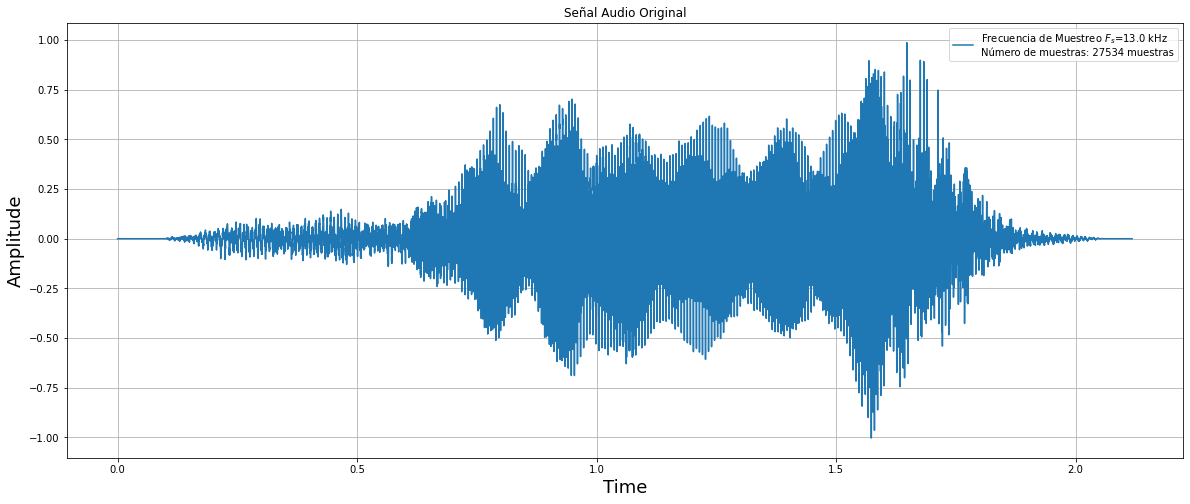

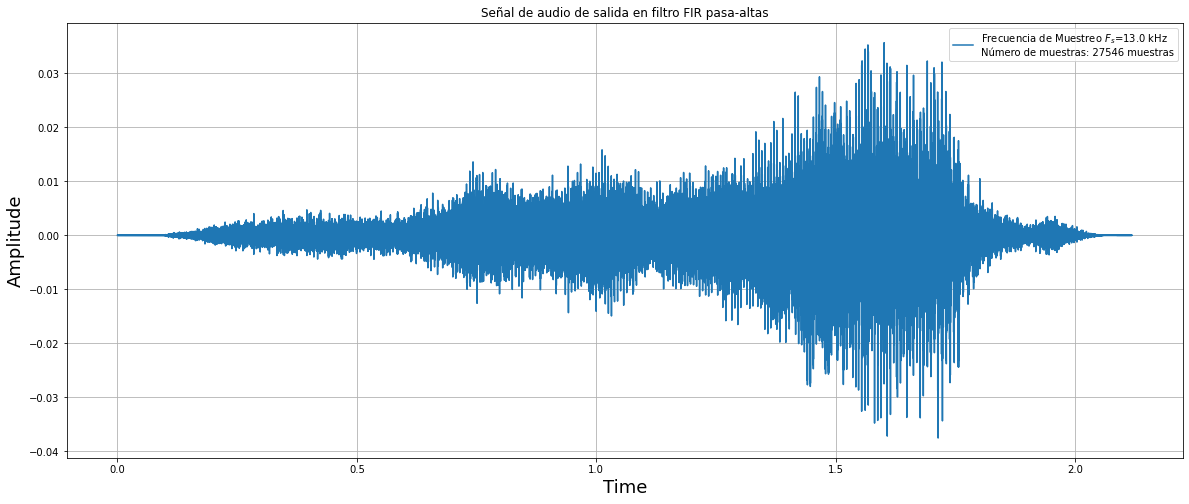

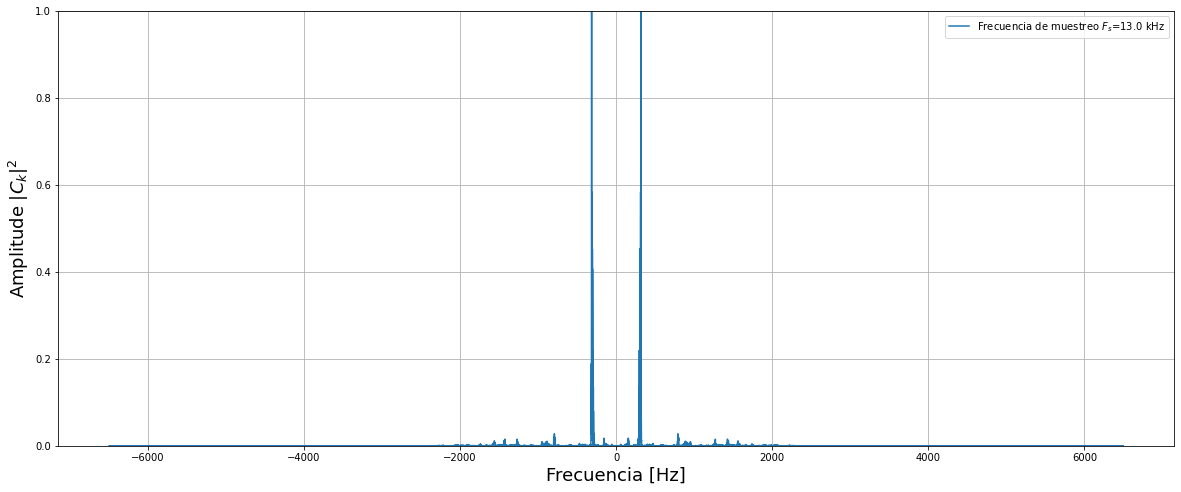

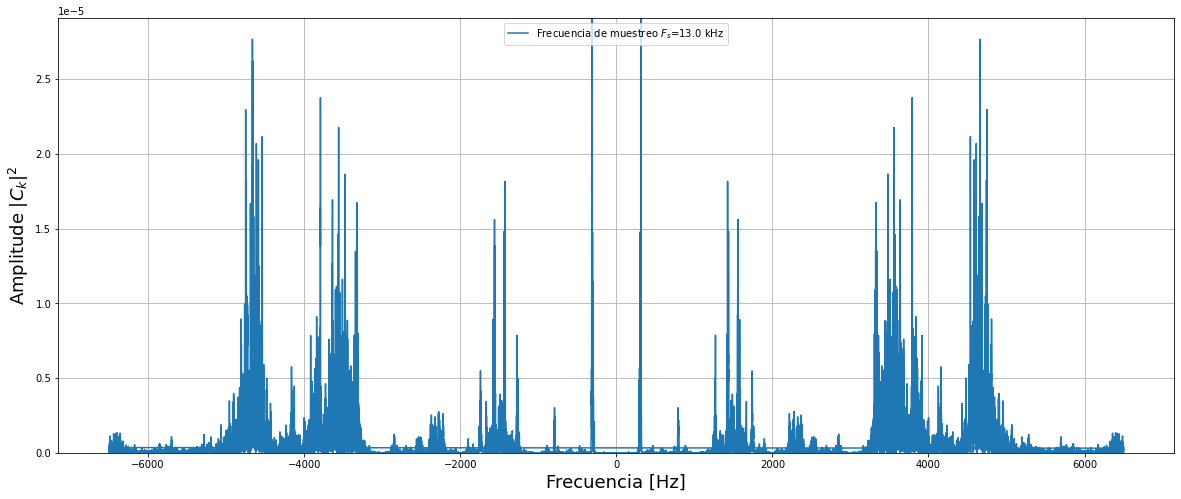






________________________________________________________________________________________________________
Audio 1; Filename: audio1.wav


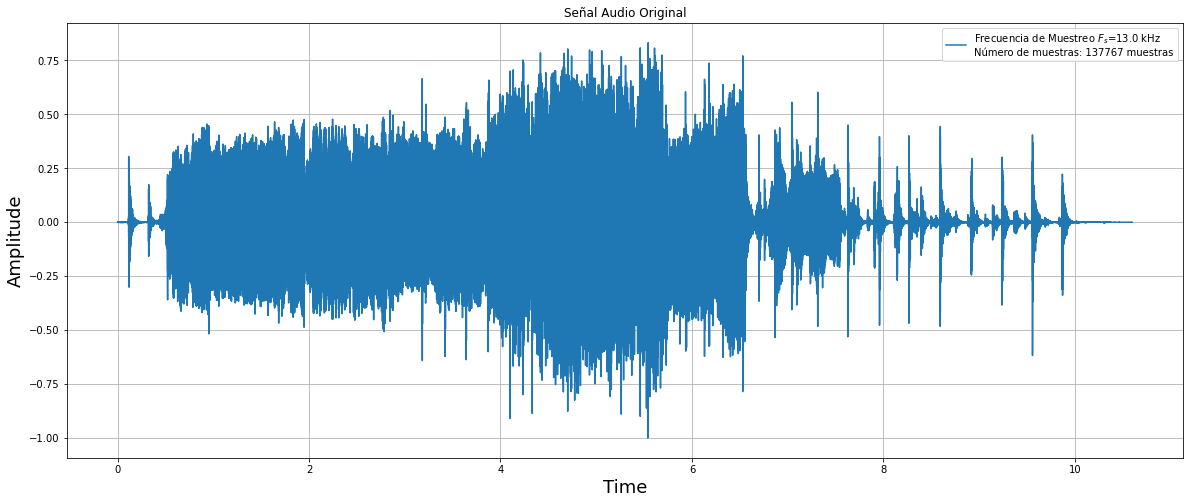

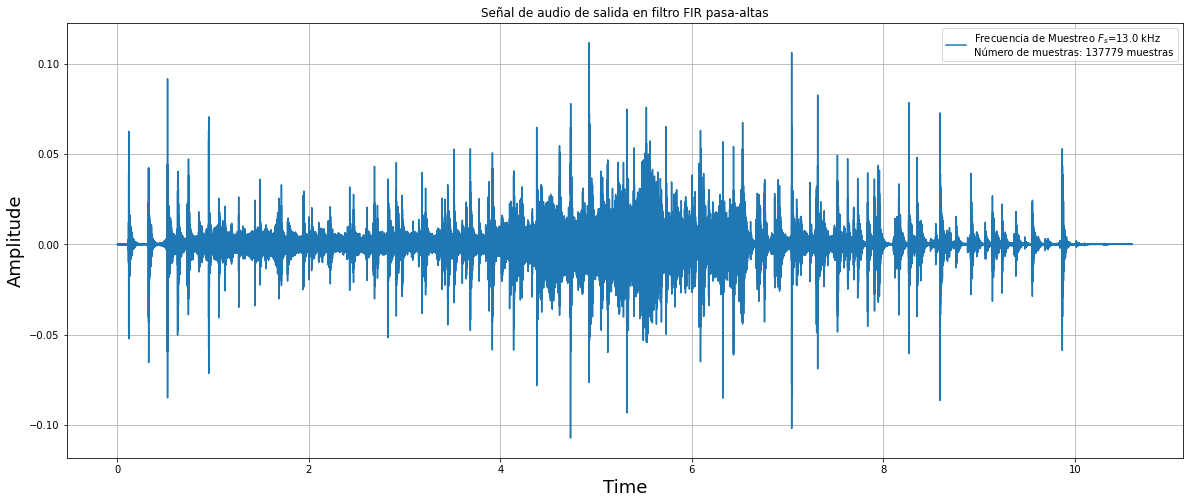

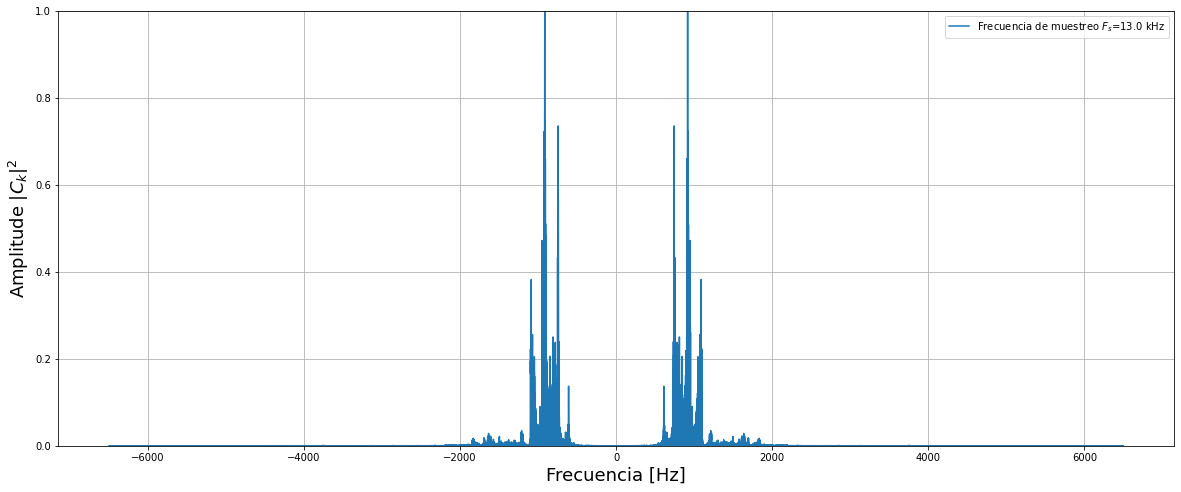

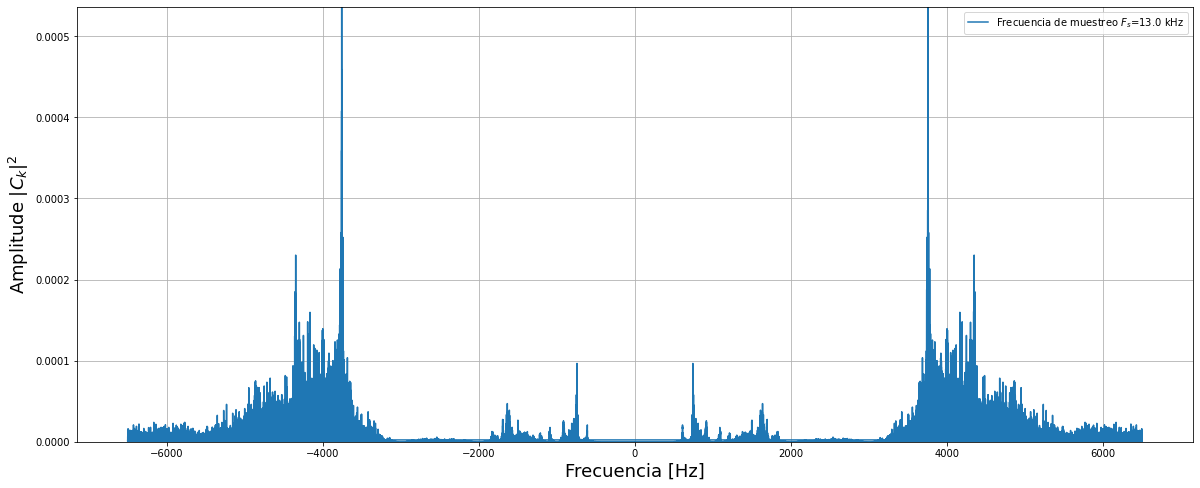






________________________________________________________________________________________________________
Audio 2; Filename: audio2.wav


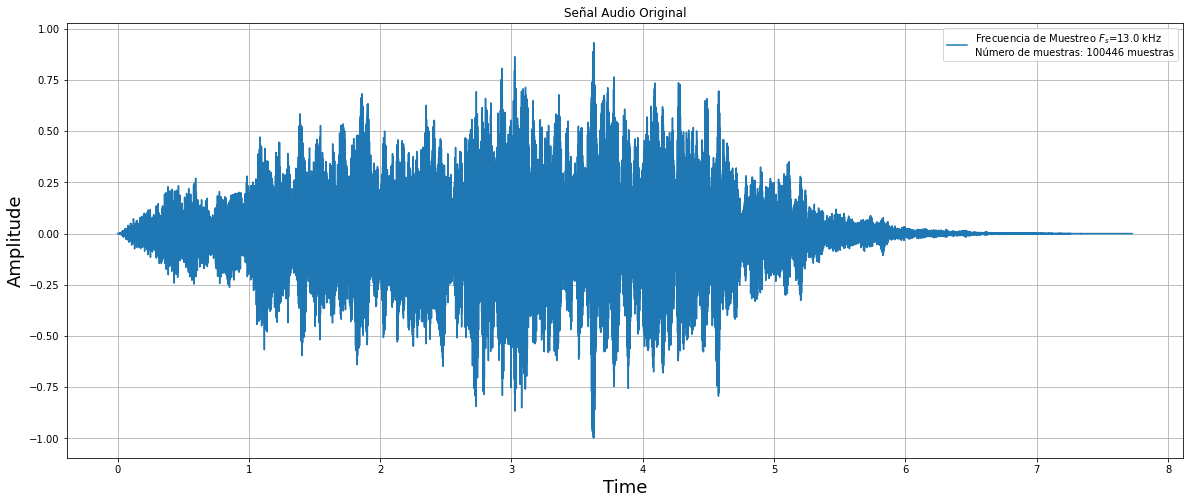

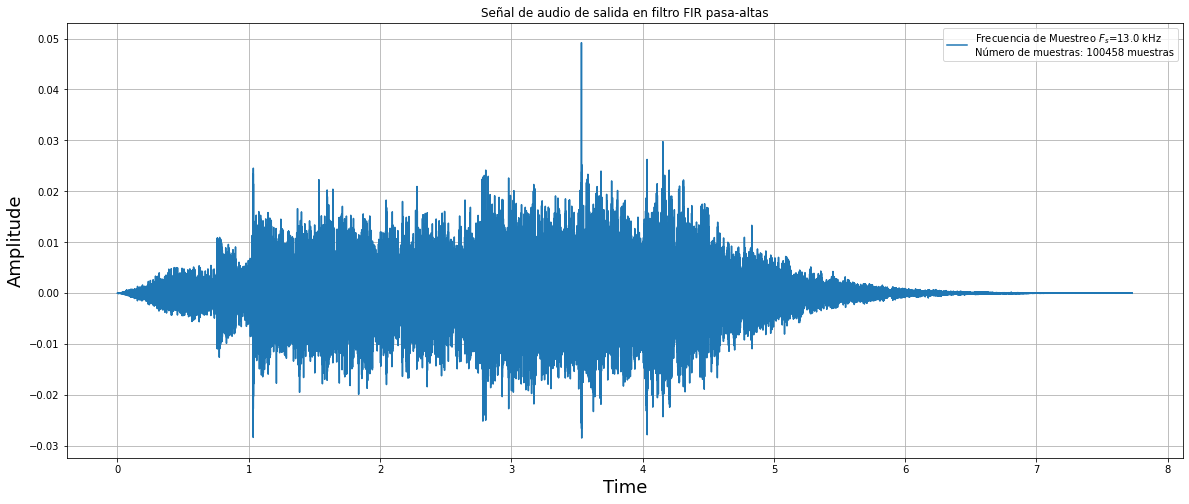

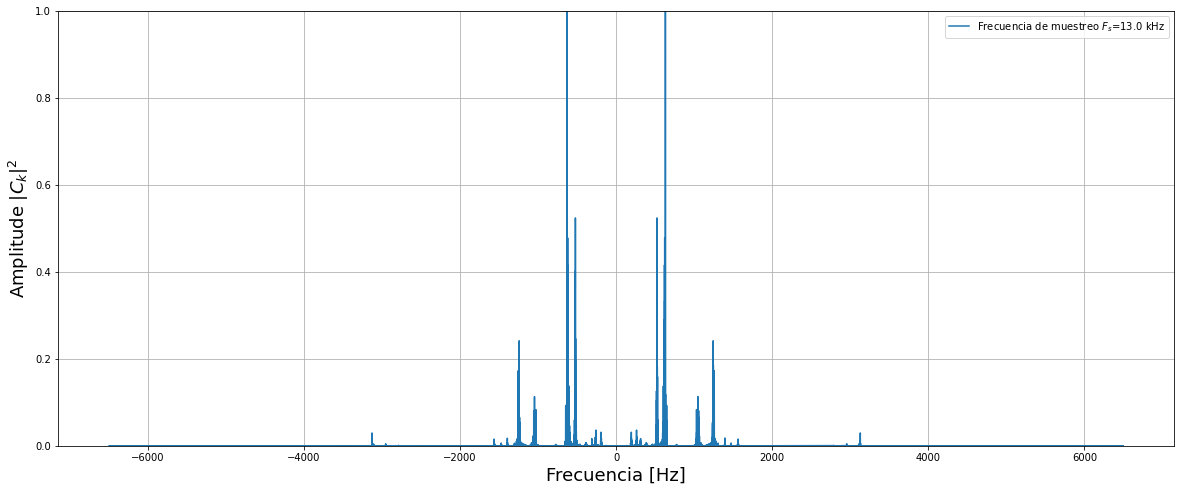

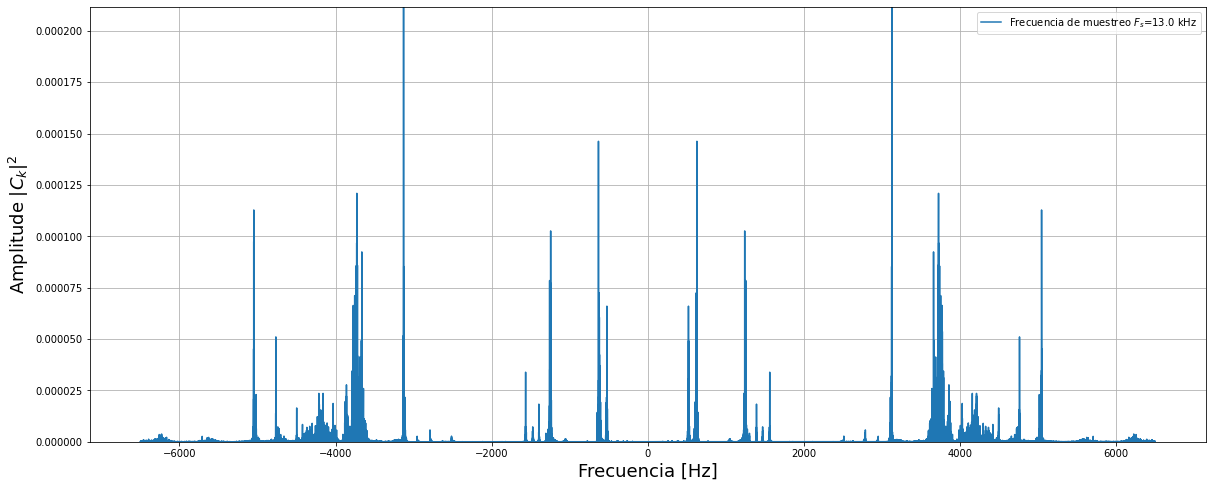

In [ ]:
#Reproduction song objects vector
push_songs=[]
for i, filename in enumerate(filenames):
    print("\n\n\n\n\n________________________________________________________________________________________________________")
    print("Audio %i; Filename:"%i, filename)
    push_songs.append(Audio(songs[i], rate=freq_songs[i]))
    
    y = np.convolve(hn,songs[i], mode="full")#Filtering de audio signal throught the designed filter.

    Y = np.fft.fft(y) #Getting frequency response of the filtered signal.
    freq_Y = np.fft.fftfreq(Y.size)*freq_songs[i]
    
    graph_audio(songs[i], freq_songs[i])
    display(push_songs[i])
    
    graph_audio(y, freq_songs[i], title = "Señal de audio de salida en filtro FIR pasa-altas")
    display(Audio(y, rate=freq_songs[i]))
    
    lims = [max(abs(SONGS[i])**2),max(abs(Y)**2)]
    plot_signal_spectrum(freq_SONGS[i], SONGS[i], freq_songs[i], lims, zoom = False)
    plot_signal_spectrum(freq_Y, Y, freq_songs[i], lims, zoom = True)

del (i)
del (filename)
del (y)
del (Y)
del (freq_Y)

Al comparar cada una de las señales obtenidas al pasar por el sistema de interés, la que más genera interés es la del primer audio relacionado al sonido de la vaca, ya que al compara el especto de la señal de entrada y salida, se observa niveles de atenuación demasiado elevados para las componentes frecuenciales menores a la frecuencia de paso ($f_c$), cerca a 10.000 veces más pequeño que en el audio original. Al reproducir la salida, se observa la diferencia en el sonido, podría confundirse con el sonido de un ternero, o una oveja que parece ser un poco más agudo que el de una vaca. 

Al analizar el siguiente audio sobre las personas aplaudiendo, podemos observar el mismo efecto, en el cual se han eliminado la mayoría de componentes de frecuencia baja. A pesar de que la señal en mención no posee componentes con alta energía en la zona de frecuencias superiores a la frecuencia de paso del filtro, se pudo observar que logró atenuar de manera adecuada las frecuencia indeseadas, y la banda de paso sigue dominando con respecto a la banda de atenuación.

Por último, para el caso del audio sobre el canto religioso, tampoco se observan componentes frecuenciales altas en gran medida, por lo cual se observa que el filtro en mención no logra atenuar por completo todas las señales no deseadas, por lo cual, para este tipo de señales, resultaría óptimo implementar otro tipo de filtro, o elevar el orden del actual (N = 13).

## II. Se realiza implementación del filtro IIR implementado en el análisis teórico.

### II. 1. Se realiza el diseño de un filtro IIR pasa-bajas con $w_c = 0.2 \pi$ usando el método de aproximación de derivadas y un filtro butterworth de primer orden (3dB) de atenuación (-3dB) en la frecuencia de corte.

(!) Se añade requerimiento adicional a gusto del estudiante con la finalidad de comparar el análisis entre ambos filtros (FIR e IIR), por ende, se obligará a que el presente filtro tenga también la misma frecuencia de corte que el filtro anterior (FIR).

#### II. 1. a. Se realiza el diseño del filtro paso a paso sin usar funciones particulares de Python para el diseño de filtros a excepción de los coeficientes del filtro Butterworth el cual se requiere a modo de consulta para continuar con los pasos metódicos.

Recordar que para un filtro analógico de primer orden, la frecuencia angular de corte tendrá un nivel de atenuación exactamente de 3 dB al deseado. Para este caso vemos que la relación $0.2 \pi = 2 \pi \frac {fc} {fs} \pi$, entonces si deseamos un valor en frecuencia fc igual al anterior caso de análisis, entonces la frecuencia de muestreo dependerá de: $f_s=\frac{2 \pi fc}{w_c}$, con $w_c -> cte$

In [ ]:
#LIBRARIES
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal

In [ ]:
#VARIABLES
Nfft = 128
T = 0.0000075

#DESIGN CONSTS
wc = 0.2*np.pi
Adb = 3 # Atenuation dB

#PARAMETERS
fs =2*np.pi*(fc) / wc
fmax = fs / 2
fc = fc # Hz Previous cut-off frequency for FIR filter

Se genera de forma programática la función de transferencia del filtro analógico generado de acuerdo a la especificaciones solicitadas del mismo. 

In [ ]:
b, a = signal.butter(1, [2*np.pi*fc], 'lowpass', analog = True, output = 'ba', fs = None) #Analogic low pass filter
b, a

(array([23247.78563656]), array([1.00000000e+00, 2.32477856e+04]))

Se observa que para las especificaciones mencionadas, la ecuación de transferencia del filtro análogo será:

$H(s)=\frac{2 \pi 3700}{s+2 \pi 3700}=\frac{2 \pi 3700}{s+2 \pi 3700}$

$F_s = 37000 [Hz]$


#### II. 1. b. Se grafica la respuesta al impulso y el espectro resultante en cada uno de los pasos metodológicos que requirió el diseño del filtro correspondiente.

Al realizar la gráfica de la respuesta del filtro Butterworth analógico de primer orden en el espectro, podemos ver

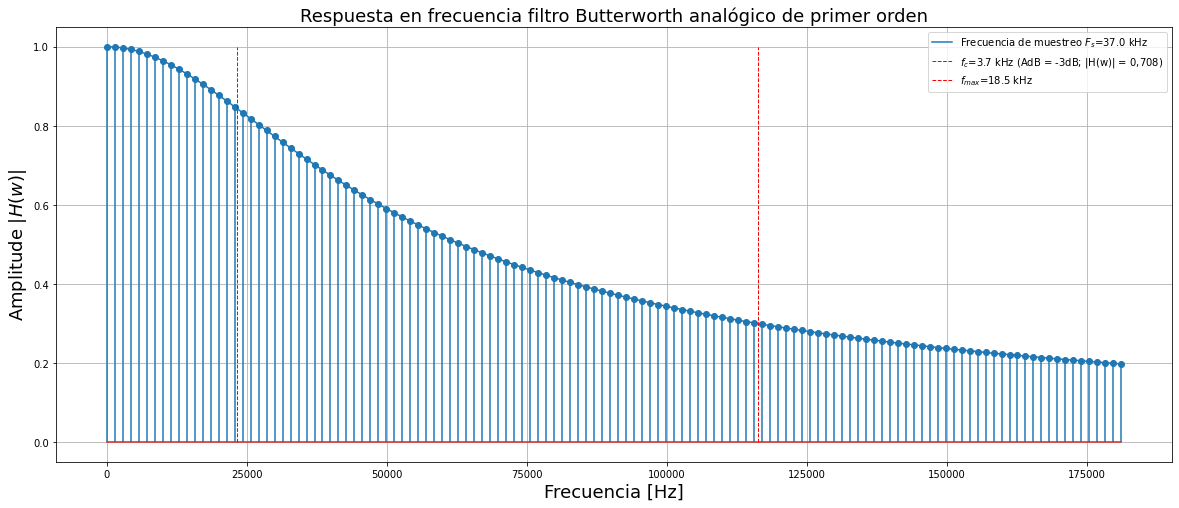

In [ ]:
def plot_signal_spectrum(freq_SIGNAL, SIGNAL, freq_signal, vlines, title, ylabel='Amplitude $|C_k|^{2}$'):
    plt.figure(figsize=(20,8))
    plt.grid()
    plt.plot(freq_SIGNAL,SIGNAL, label = 'Frecuencia de muestreo $F_s$=%0.1f kHz'%(freq_signal*10**-3))
    plt.stem(freq_SIGNAL,SIGNAL)
    
    plt.vlines(vlines[0], 0,1, color='g', lw=1, linestyle='--', label='$f_c$=%0.1f kHz (AdB = -3dB; |H(w)| = 0,708)'%(fc*10**-3))
    plt.vlines(vlines[1], 0,1, color='r', lw=1, linestyle='--', label='$f_{max}$=%0.1f kHz'%(fmax*10**-3))

    plt.xlabel('Frecuencia [Hz]',fontsize=18) # x Axis
    plt.ylabel(ylabel,fontsize=18) # Y Axis
    plt.title(title, fontsize=18)
    plt.legend()
    plt.show()
    
    
vlines = [2*np.pi*fc, 2*np.pi*fmax]

w = np.arange(0, 2*np.pi*fmax, 2*np.pi*fmax/Nfft)
w, h = signal.freqs(b,a, worN = w)
plot_signal_spectrum(w / 2*np.pi, np.abs(h), fs, vlines, title='Respuesta en frecuencia filtro Butterworth analógico de primer orden', ylabel = 'Amplitude $|H(w)|$')

Luego, para transformar el filtro analógico en mención, a un filtro digital recursivo de primer orden (IIR), debemos hacer:

$s^{k} = (\frac{1-z^{-1}}{T})^{k} => s = \frac{1-z^{-1}}{T}, k=1 $

De esta manera, tenemos que la función de transferencia en el plano Z, será: 

$H(z) = \frac{2 \pi f_c Tz}{(1+2 \pi f_c T)z-1} = \frac{2 \pi 3700Tz}{(1+2 \pi 3700T)z-1} $

Para volver causal el filtro IIR, es necesario que los polos del filtro estén contenidos en la circunferencia unidad $|z|<1 => z = |\frac{1}{1+2 \pi f_cT}| < 1$, por ende, al resolver la inecuación, podemos observar que para cualquier $ T < \frac{-2}{2 \pi f_c}$ or $T > 0$, se puede tener un filtro causal.

Si deseáramos analizar en el dominio de la frecuencia, podríamos aplicar la transformada de Fourier haciendo $z=e^{\frac{j2 \pi k n}{N}}$ con la finalidad de convertir la función de transferencia en el plazo Z, en la función de transferencia $H(k)$ discreta deseada.


$H(k) = \frac{2 \pi 3700Te^{\frac{j2 \pi k n}{N}}}{(1+2 \pi 3700T)e^{\frac{j2 \pi k n}{N}}-1} $

Por ejemplo, si graficamos generamos 8 muestras de la transformada, usando el T mencionado anteriormente, tenemos:

In [ ]:
def den(N, T):
    n = np.arange(N)
    k= np.arange(N)
    den = ((1+2*np.pi*3700*T)*np.exp(1j* 2*np.pi/N *k*n) -1)
    return den

def Hk(N, T):
    k= np.arange(N)
    n = np.arange(N)
    Hk = 2*np.pi*3700*T*np.exp(1j* 2*np.pi/N *k*n) / ((1+2*np.pi*3700*T)*np.exp(1j* 2*np.pi/N *k*n) -1)
    return Hk
#e.g.
Hk(8, T)

array([1.        +0.00000000e+00j, 0.11341572-1.71635627e-01j,
       0.08018843-4.51639013e-18j, 0.11341572-1.71635627e-01j,
       1.        +2.80949321e-15j, 0.11341572-1.71635627e-01j,
       0.08018843-4.06475112e-17j, 0.11341572-1.71635627e-01j])

Ahora se realizará la gráfica respectiva para el diagrama de polos y ceros del nuevo filtro generado (IIR), del cual se pudo observar que tantos sus ceros como sus polos se encuentran contenidos en la circunferencia unidad, lo que corrobora el hecho de que los coeficientes corresponden a un filtro causal y estable.

numerador:  [0.17435839227423353, 0]
denominador:  [1.1743583922742336, -1]


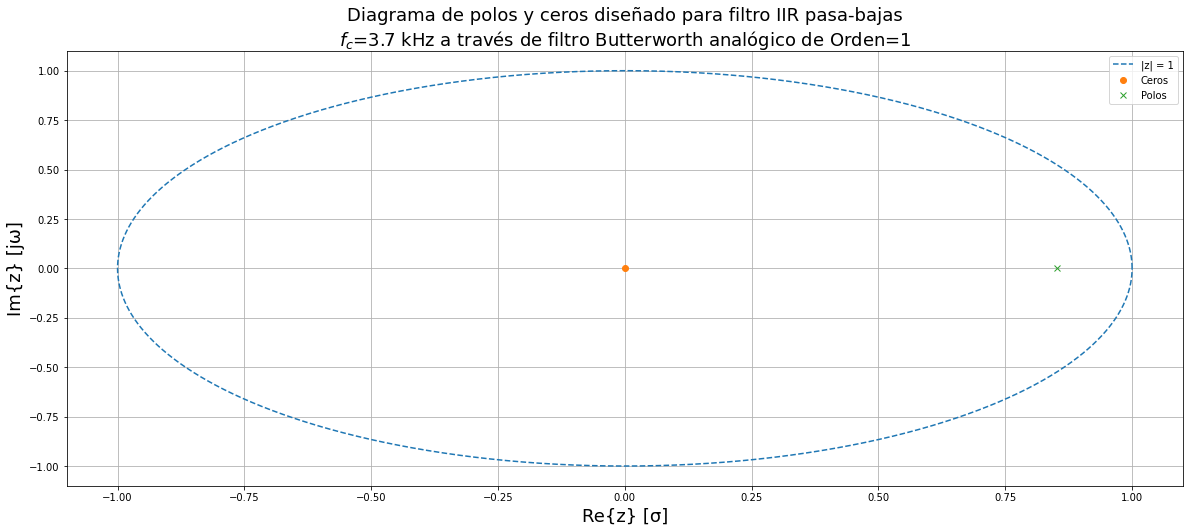

In [ ]:
def plot_zeros_and_poles(num, den = 1, title = 'Diagrama de polos y ceros diseñado para filtro FIR pasa-altas\n$f_c$=%0.1f kHz\tOrden=%0.f'%(fc*10**-3,N)):
    w , hw = signal.freqz(num, den)
    sys1=signal.lti(num, den)
    ang=np.arange(0.0,2*np.pi,1/Fs)
    xp=np.cos(ang)
    yp=np.sin(ang)
    
    %matplotlib inline
    plt.figure(figsize=(20,8))
    plt.title(title, fontsize = 18)
    plt.xlabel('Re{z} [σ]',fontsize=18)
    plt.ylabel('Im{z} [jω]',fontsize=18)
    plt.plot(xp,yp,'--', label = '|z| = 1')
    plt.plot(sys1.zeros.real, sys1.zeros.imag, 'o', label = 'Ceros')
    plt.plot(sys1.poles.real, sys1.poles.imag, 'x', label = 'Polos')
    plt.legend()
    plt.grid()

plot_zeros_and_poles(hn)

b11 = [2*np.pi*3700*T, 0]
a11 = [1 + 2*np.pi*3700*T, -1]
plot_zeros_and_poles(b11,a11, title='Diagrama de polos y ceros diseñado para filtro IIR pasa-bajas\n$f_c$=%0.1f kHz a través de filtro Butterworth analógico de Orden=1'%(fc*10**-3))
print ("numerador: ",b11)
print("denominador: ",a11)

Como ya pudimos corroborar que el filtro puede ser diseñado en la práctica, vamos a efectuar la respuesta del filtro al impulso unitario, de esta manera podremos analizar el comportamiento del filtro para la frecuencia de corte asignada inicialmente.

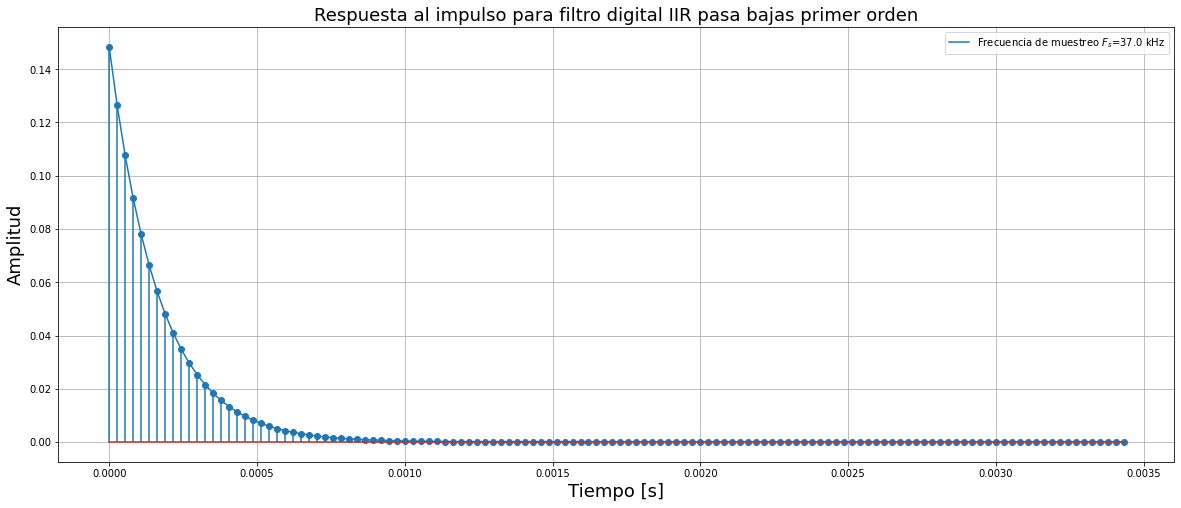

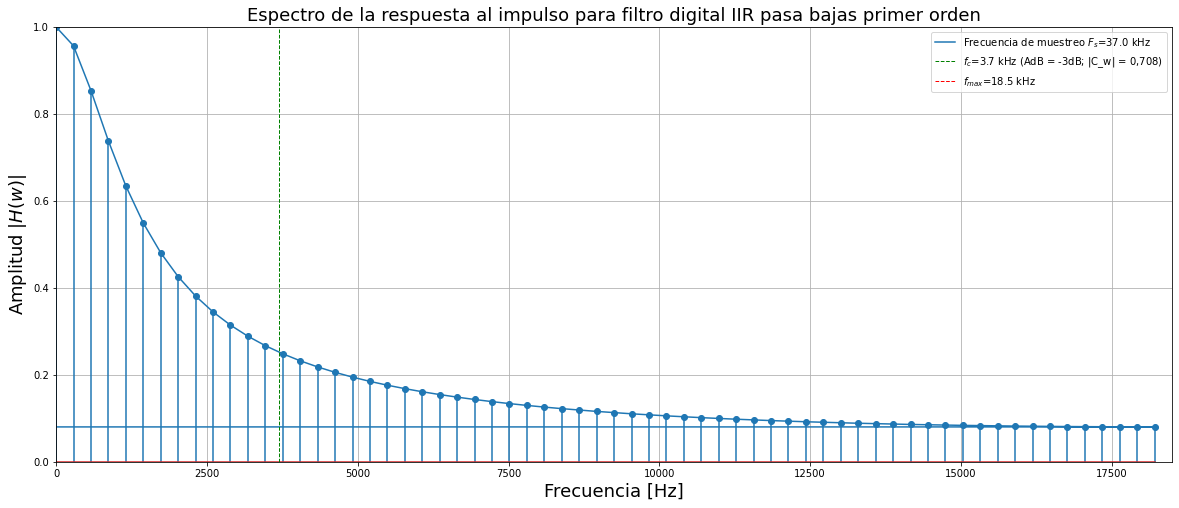

In [ ]:
import scipy.signal as signal
from pylab import repeat
import matplotlib.pyplot as plt
import numpy as np
    
def impz(b,a):
    l = Nfft
    impulse = repeat(0.,l); impulse[0] =1.
    x = np.arange(0,l)
    response = signal.lfilter(b,a,impulse)
    t = (1/fs)*x
    return t, response

def graph_impz(t, response):
    plt.figure(figsize=(20,8))
    plt.grid()
    plt.plot(t, response, label = 'Frecuencia de muestreo $F_s$=%0.1f kHz'%(fs*10**-3))
    plt.stem(t, response)
    plt.xlabel('Tiempo [s]',fontsize=18) # x Axis
    plt.ylabel('Amplitud',fontsize=18) # Y Axis
    plt.title('Respuesta al impulso para filtro digital IIR pasa bajas primer orden', fontsize=18)
    plt.legend()
    plt.show()

def plot_frequency_response(freq_SIGNAL, SIGNAL, freq_signal, lims, zoom = False, title = ''):
    plt.figure(figsize=(20,8))
    plt.grid()
    plt.plot(freq_SIGNAL,abs(SIGNAL) / max(lims), label = 'Frecuencia de muestreo $F_s$=%0.1f kHz'%(fs*10**-3))
    plt.stem(freq_SIGNAL,abs(SIGNAL) / max(lims))
    plt.axvline(fc, color='g', lw=1, linestyle='--', label='$f_c$=%0.1f kHz (AdB = -3dB; |C_w| = 0,708)'%(fc*10**-3))
    plt.axvline(fmax, color='r', lw=1, linestyle='--', label='$f_{max}$=%0.1f kHz'%(fmax*10**-3))
    
    normalized_lims = [0.0 , 1.0] if not(zoom) else [0.0, float(min(lims)/max(lims))] #zoom config
    plt.ylim(normalized_lims)
    plt.xlim([0.0 , fs/2])
    plt.xlabel('Frecuencia [Hz]',fontsize=18) # x Axis
    plt.ylabel('Amplitud $|H(w)|$',fontsize=18) # Y Axis
    plt.title('Espectro de la respuesta al impulso para filtro digital IIR pasa bajas primer orden', fontsize=18)
    plt.legend()
    plt.show()

t, hn = impz(b11,a11)

graph_impz(t, hn)
    
Hn = np.fft.fft(hn) #Getting frequency response of the filtered signal.
freq_Hn = np.fft.fftfreq(Hn.size)*fs

plot_frequency_response(freq_Hn, Hn, fs, lims=[0,max(abs(Hn))])

De esta manera como se conoce la respuesta al impulso del filtro en mención tanto en el tiempo como en la frecuencia, se podrá calcular la salida de cualquier señal de entrada a dicho filtro a través de operaciones en el tiempo (convolución) o en la frecuencia, por lo cual no existirá ninguna limitante para el análisis del filtrado de los tres audios implementados en el análisis del caso anterior.

#### II. 1. c. Se analiza la respuesta en frecuencia, se opina sobre sus características, se grafica la respuesta en frecuencia de ambos filtros analógico y el filtro digital obtenido a partir de éste.

Es bien conocido el hecho de que en la práctica nunca obtendremos un filtro con respuesta al impulso igual a la deseada en el efecto del diseño, esto es a causa de la cantidad infinita de muestras N (orden del filtro) requeridas al momento de realizar la transformada inversa discreta de fourier (IDFT).

Al iterar varias veces el período arbitrario T, se pudo observar que al iterar con el período T = 0.0000075, la función de transferencia resultante $H(z)=\frac{0.02775z}{(1.02775)z-1}$ parece sobrepasar los requisitos requeridos de atenuación (-3dB) para la frecuencia de corte, por lo cual se dejará el valor del período en mención para dar continuidad con el análisis.

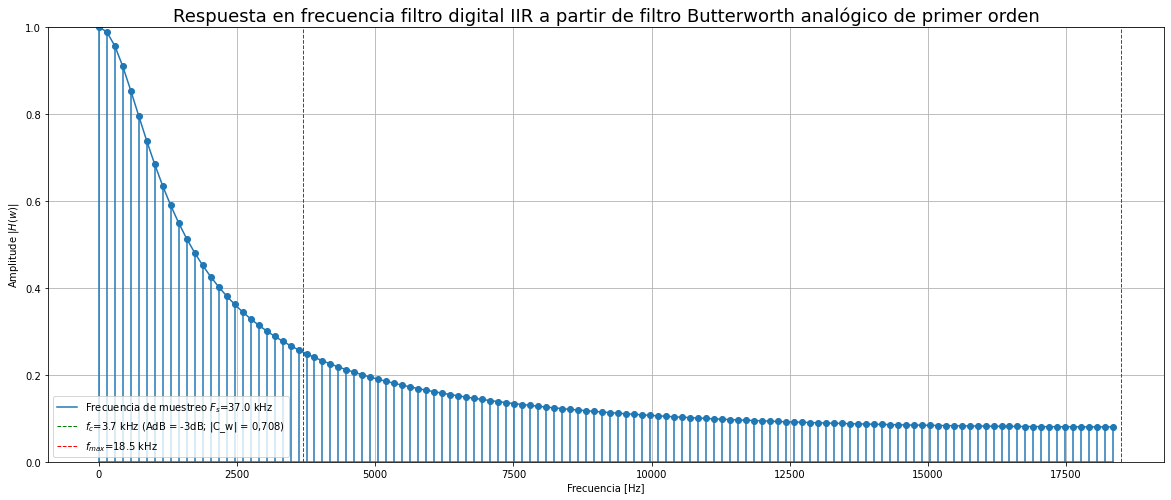

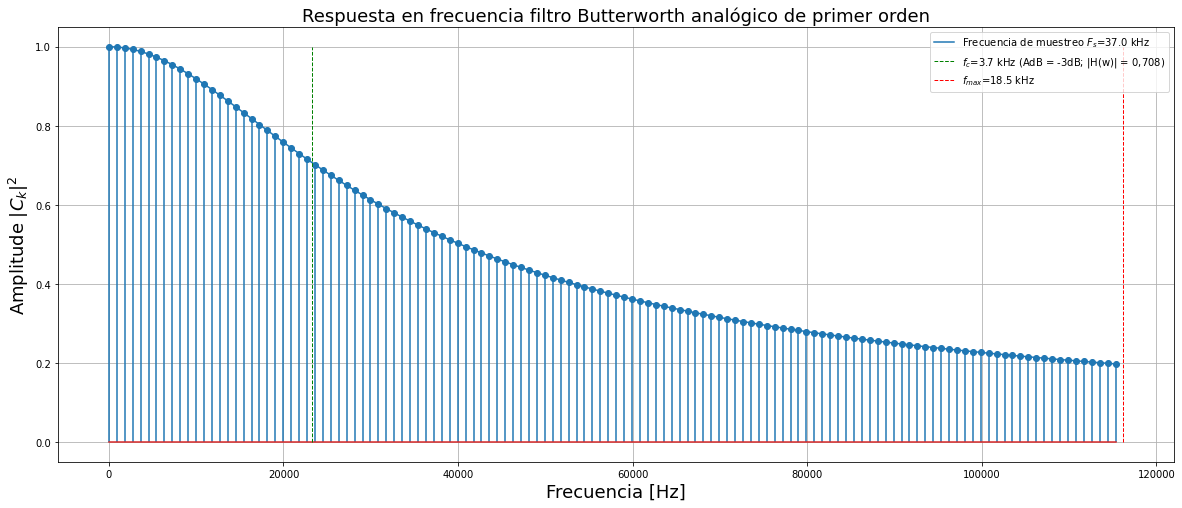

In [ ]:

wb, Hb = signal.freqz(b11, a11, worN = Nfft)
wb = np.arange(0, fmax, fmax/Nfft)
plt.figure(figsize=(20,8))
plt.title('Respuesta en frecuencia filtro digital IIR a partir de filtro Butterworth analógico de primer orden',fontsize=18)
plt.plot(wb,np.abs(Hb),label='Frecuencia de muestreo $F_s$=%0.1f kHz'%(fs*10**-3))
plt.stem(wb,np.abs(Hb))
plt.axvline(fc, color='g', lw=1, linestyle='--', label='$f_c$=%0.1f kHz (AdB = -3dB; |C_w| = 0,708)'%(fc*10**-3))
plt.axvline(fmax, color='r', lw=1, linestyle='--', label='$f_{max}$=%0.1f kHz'%(fmax*10**-3))
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitude $|H(w)|$')
plt.ylim([0,1])
plt.legend()
plt.grid()
plt.show()

w = np.arange(0, 2*np.pi*fmax, 2*np.pi*fmax/Nfft)
w, h = signal.freqs(b,a, worN = w)
plot_signal_spectrum(w , np.abs(h), fs, vlines, title='Respuesta en frecuencia filtro Butterworth analógico de primer orden')

Con el valor asignado para el período T = 0.0000075, podemos observar que el filtro IIR en mención puede lograr atenuarse en alrededor de tres veces más que en el caso del filtro Butterworth analógico de primer orden. Además se puede observar que las componentes frecuenciales que se encuentran dentro de la banda de paso (antes de la frecuencia de corte) también sufrieron el fenómeno de atenuación, en el cual las componentes en $\frac{f_c}{2}$ se atenuan en la mitad del valor original. Esto se podría comprender como si la variable T hubiera generado un efecto relativo en el desplazamiento de la frecuencia de corte al momento de diseñarse el filtro en la realidad.

Sin embargo, el período asignado fue obtenido al iterar estratégicamente para obtener un filtro arbitrario, es decir, que podemos con la variable T, generar infinitas respuestas en frecuencia. NO fue posible lograr obtener una relación que permitiera obtener el T deseado para una frecuencia de corte y atenuación deseada de forma teórica, el resultado anterior se obtuvo usando iterando usando la estrategia del algoritmo de búsqueda binaria y a modo manual, (no se programó).



#### d. Se adiciona un análisis de la fase

Al realizar un análisis sobre la fase del filtro IIR en mención, podemos observar que efectivamente se dejó de cumplir con la propiedad de linealidad de fase mencionada en el sistema anterior (Filtro pasa-altas FIR). Esto es a causa de que al ser un filtro recursivo, sus entradas están re-alimentadas por la salida, y dependerán de estados iniciales (memoria), esto implica la consecuencia en que la fase no sea lineal.


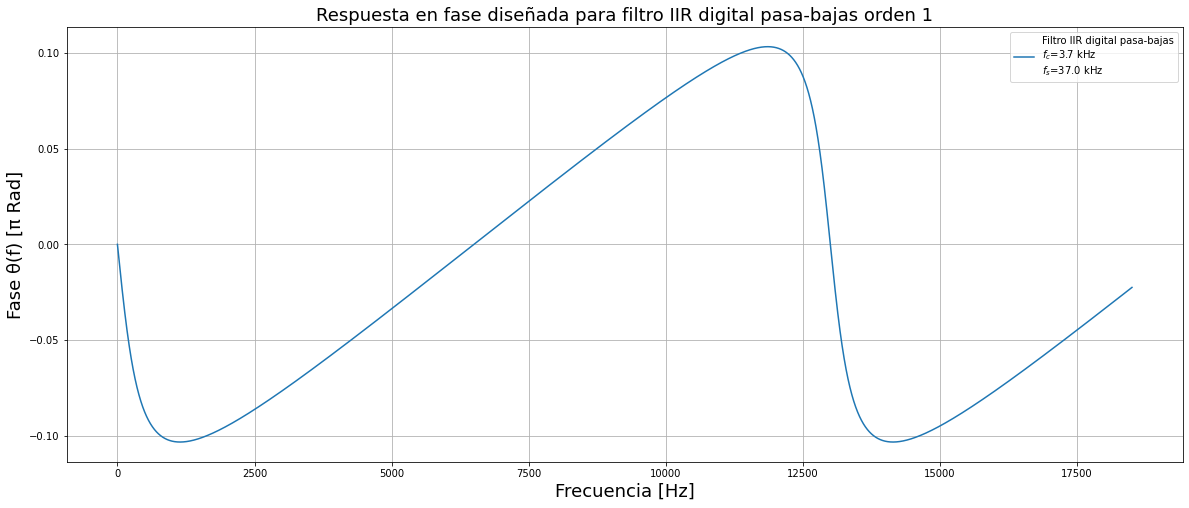

In [ ]:
#Getting phase response caused by the designed filter
def get_IIR_phase_response(num, den, N):
    f = np.arange(0, fmax, Nfft/fs)
    _ , hw = signal.freqz(num, den, worN = f, fs = Fs)#get_centered_interval(N, isZeroFirst))
    tetha = np.unwrap(np.angle(hw)) / np.pi
    return f, tetha

#Plot phase response caused by the designed filter
def plot_IIR_filter_phase_response(f, tetha, stem = True):
    tetha = tetha / np.pi
    %matplotlib inline
    plt.figure(figsize=(20,8))
    plt.title("Respuesta en fase diseñada para filtro IIR digital pasa-bajas orden 1", fontsize = 18)
    plt.xlabel('Frecuencia [Hz]',fontsize=18)
    plt.ylabel('Fase θ(f) [π Rad]',fontsize=18)
    plt.grid()
    if stem: plt.stem(f, tetha)
    plt.plot(f, tetha, label = 'Filtro IIR digital pasa-bajas\n$f_c$=%0.1f kHz\n$f_s$=%0.1f kHz'%(fc*10**-3,fs*10**-3))
    plt.legend()
    plt.legend()

f, tetha = get_IIR_phase_response(b11, a11, N = Nfft)
plot_IIR_filter_phase_response(f, tetha, stem = False)


Sin embargo, de acuerdo a la gráfica de fase observada, se observan ciertos rangos o porciones de frecuencia, en las cuales la fase presenta propiedades de linealidad y se podría aproximar a una recta.

Cabe destacar que a pesar de no existir linealidad en la fase, siguie existiendo una cierta simetría o "belleza" en la gráfica de la fase, se podría observar como una gráfica de una función senoidal que inicialmente se encontraba en el eje xy, pero que ha sufrido una especie de rotación con respecto del eje x, y en la cual el observador se encuentra en un plano diferente al plano de rotación de la señal en mención (señal bidimensional rotando sobre eje coordenado y pasa a estar en un espacio tridimensional para generar perspectiva).

### II. 2. Comparación de los filtros diseñados en simulación con los filtros diseñados en la componente teórica indicando todos los posibles errores cometidos.

Si comparamos los resultados en la práctica junto con los aspectos definidos en el apartado teórico, podemos observar diferencias notables sobre los errores cometidos en esta última. 

El primer inconveniente se obtuvo al no tenerse certeza suficiente sobre la forma general de la función de transferencia de los filtros tipo Butterworth y de qué manera las constantes allí presentes (para el caso análogo) se debían transformar de forma apropiada al nuevo sistema (caso digital), por lo cual se entró en confusión y se decidió asumir una forma arbitraria, que en ningún momento aplicó a la realidad.

Del mismo modo, para el caso práctico, se presentaron grandes dificultades al momento de realizar los análisis, y el principal motivo de esto es el mismo que se observa sobre la confusión del tipo de unidades a implementar para la entrada o salida de una función, ya que en algunos casos se requiere que sea en frecuencia, frecuencia angular o incluso normalizarlas.

El caso de análisis actual nos permitió observar otras alternativas a diseños de filtros mediantes transformaciones debidamente aplicadas podremos hacer aprovechamiento de un sistema bien definido y de mayor simpleza sobre un sistema poco definido (caja negra) y de mayor complejidad.

### 3. Se cargan 3 audios cortos y se usan como entrada para el filtro en mención. Se realiza un análisis espectral para cada caso.

Igualmente que el caso anterior, se desea corroborar la funcionalidad correcta del filtro, por lo cual se creará una señal artificial de la cual la frecuencia dependa del tiempo de forma polinómica con un orden arbitatrio (frequency_order) que permita generar una señal con componentes frecuenciales en todo el espectro desde $\frac{-F_s}{2}$ hasta  $\frac{+F_s}{2}$, se grafica el espectro de dicha señal, se reproduce, y se compara con la salida del filtro.

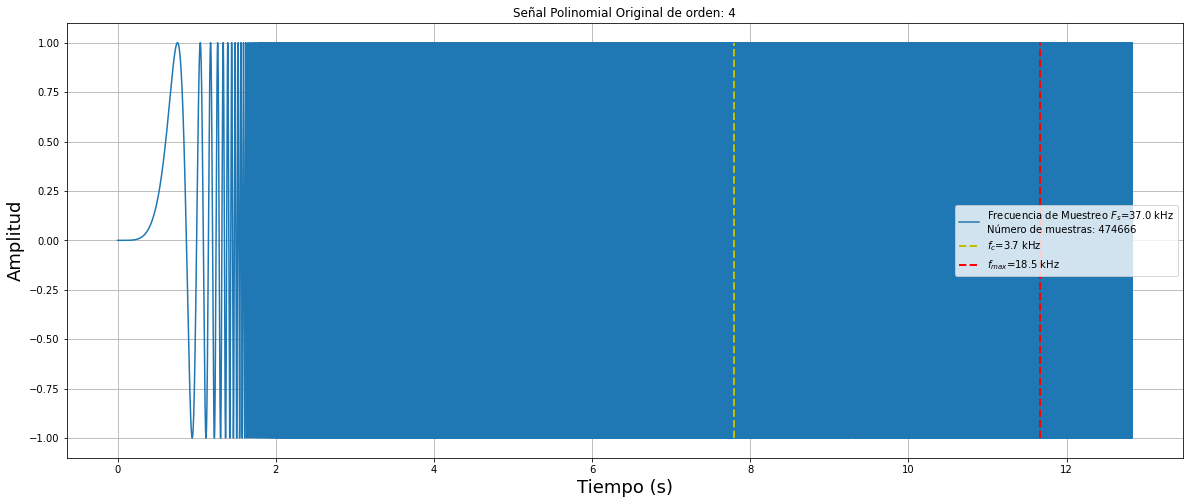

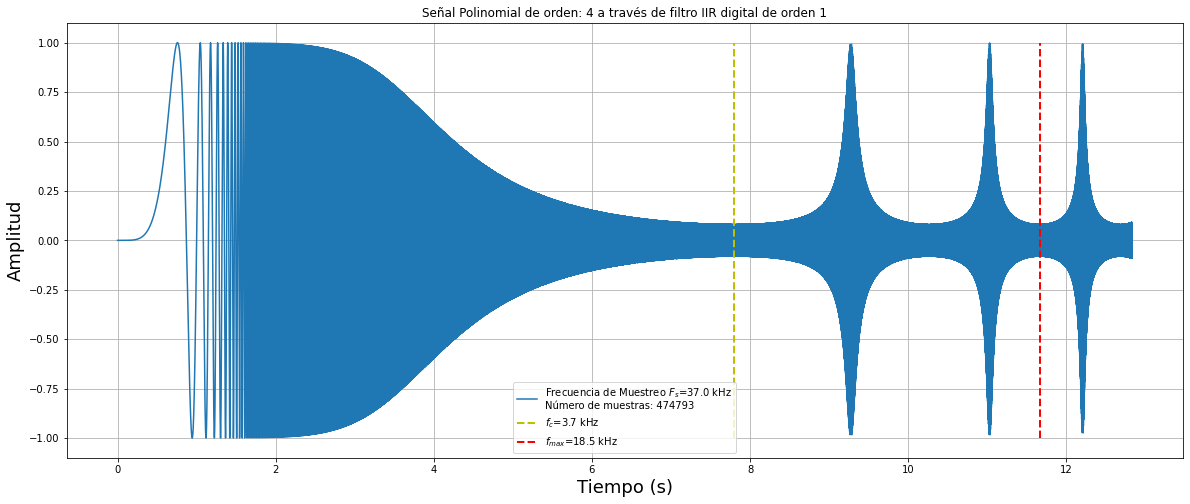

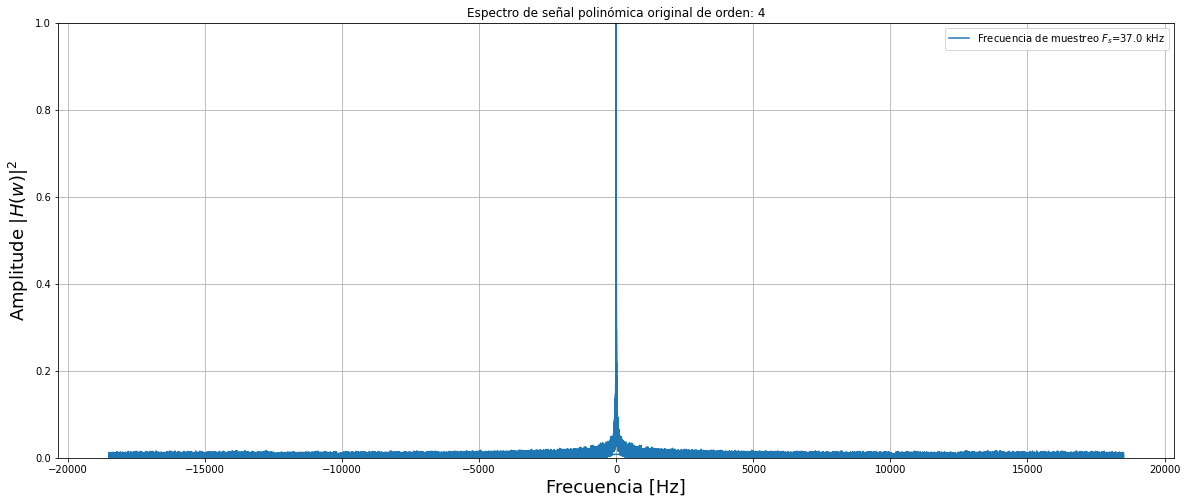

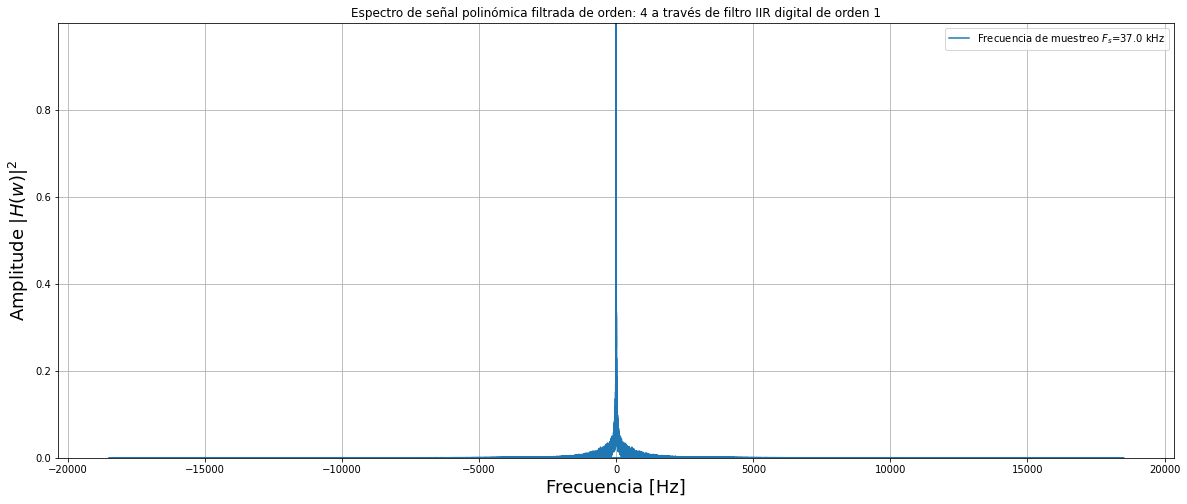

In [ ]:
from IPython.display import Audio # para escuchar la senal

#Sinusoidal signal const
frequency_order = 4
freq_signal = fs
aliasing_factor = 1.1 # If the factor > 1, there will be aliasing for the output of the digital filter.

def impz(b,a):
    l = Nfft
    impulse = repeat(0.,l); impulse[0] =1.
    x = np.arange(0,l)
    response = signal.lfilter(b,a,impulse)
    t = (1/fs)*x
    return t, response

def make_polinomial_signal(frequency_order, freq_signal, freq_filter):
    last_t = (freq_filter/2)**(1/frequency_order)
    t = np.arange(0, aliasing_factor*last_t, 1.0/freq_signal) # Vector de tiempo
    f = t**frequency_order
    x = np.sin(2*np.pi*f*t)
    
    #Resampling the signal in order to make a signal with the same sample frequency of the designed filter.
    if freq_signal != freq_filter:
        signal_time = (len(x)/freq_signal)
        new_samples_number = int(signal_time*freq_filter)
        x = signal.resample(x, new_samples_number)
    return x

def deleting_residuals(t, x):
    #Deleting residual samples caused by the convolutions process.
    sizes = [len(t), len(x)]
    if sizes[1] - sizes[0] > 0: x = x[:-(sizes[1] - sizes[0])]
    elif sizes[0] - sizes[1] > 0: t = t[:-(sizes[0] - sizes[1])]
    return t, x

def plot_signal_spectrum(freq_SIGNAL, SIGNAL, freq_signal, lims, zoom = False, title = ''):
    plt.figure(figsize=(20,8))
    plt.grid()
    plt.plot(freq_SIGNAL,abs(SIGNAL)**2 / max(lims), label = 'Frecuencia de muestreo $F_s$=%0.1f kHz'%(freq_signal*10**-3))
    
    normalized_lims = [0.0 , 1.0] if not(zoom) else [0.0, float(min(lims)/max(lims))] #zoom config
    plt.ylim(normalized_lims)
    plt.xlabel('Frecuencia [Hz]',fontsize=18) # x Axis
    plt.ylabel('Amplitude $|H(w)|^{2}$',fontsize=18) # Y Axis
    plt.title(title)
    plt.legend()
    plt.show()
    
x = make_polinomial_signal(frequency_order, freq_signal, fs)
X = np.fft.fft(x) #Getting frequency response of the filtered signal.
freq_X = np.fft.fftfreq(X.size)*freq_signal

t, hn = impz(b11,a11)
y = np.convolve(hn,x, mode="full")#Filtering de audio signal throught the designed filter.
Y = np.fft.fft(y) #Getting frequency response of the filtered signal.
freq_Y = np.fft.fftfreq(Y.size)*freq_signal

t=np.arange(0, float(len(x))/freq_signal, 1.0/freq_signal)
t, x = deleting_residuals(t, x)

plt.figure(figsize=(20,8))
plt.grid()
plt.plot(t,x, label = 'Frecuencia de Muestreo $F_s$=%0.1f kHz\nNúmero de muestras: %i'%(freq_signal*10**-3, len(x)))
plt.xlabel('Tiempo (s)',fontsize=18) # x Axis
plt.ylabel('Amplitud',fontsize=18) # Y Axis
plt.title('Señal Polinomial Original de orden: %i'%frequency_order)
last_t_fc= (fc)**(1/frequency_order)
last_t_fmax= (fmax)**(1/frequency_order)
plt.vlines(last_t_fc, -1,1, color='y', lw=2, linestyle='--', label='$f_c$=%0.1f kHz'%(fc*10**-3))
plt.vlines(last_t_fmax, -1,1, color='r', lw=2, linestyle='--', label='$f_{max}$=%0.1f kHz'%(fmax*10**-3))
plt.legend()
plt.show()

display(Audio(x, rate=freq_signal))

t = np.arange(0, float(float(len(y))/freq_signal), 1.0/freq_signal)
t, x = deleting_residuals(t, y)
    
plt.figure(figsize=(20,8))
plt.grid()
plt.plot(t,y, label = 'Frecuencia de Muestreo $F_s$=%0.1f kHz\nNúmero de muestras: %i'%(freq_signal*10**-3, len(y)))
plt.vlines(last_t_fc, -1,1, color='y', lw=2, linestyle='--', label='$f_c$=%0.1f kHz'%(fc*10**-3))
plt.vlines(last_t_fmax, -1,1, color='r', lw=2, linestyle='--', label='$f_{max}$=%0.1f kHz'%(fmax*10**-3))

plt.xlabel('Tiempo (s)',fontsize=18) # x Axis
plt.ylabel('Amplitud',fontsize=18) # Y AxisAxis
plt.title('Señal Polinomial de orden: %i a través de filtro IIR digital de orden 1'%frequency_order)
plt.legend()
plt.show()

display(Audio(y, rate=freq_signal))

lims = [max(abs(X)**2), max(abs(Y)**2)]
plot_signal_spectrum(freq_X, X, freq_signal, lims, zoom = False, title = 'Espectro de señal polinómica original de orden: %i'%frequency_order)

#Fixing traslaping output due by FFT method
index = len(freq_Y)//2 if freq_signal >= fs else len(freq_Y)//2 + 1
freq_Y = np.concatenate((freq_Y[index:], freq_Y[:index]), axis=None)
Y = np.concatenate((Y[index:], Y[:index]), axis=None)

plot_signal_spectrum(freq_Y, Y, freq_signal, lims, zoom = True, title = 'Espectro de señal polinómica filtrada de orden: %i a través de filtro IIR digital de orden 1'%frequency_order)


Para este caso podemos observar nuevamente que el filtro diseñado parece atenuar las componentes frecuenciales luego de los 4kHz cercano a la frecuencia de corte requerida en el diseño. Se puede observar en la gráfica de la señal con respecto al tiempo que existen una líneas que representan el momento exacto en el tiempo en el cual la señal artificial alcanza la frecuencia de corte del filtro ( 𝑓𝑐 ) y la frecuencia de Nyquist del mismo ( 𝑓𝑚𝑎𝑥 ), se puso a propósito una señal que tenía componentes frecuenciales superiores a la frecuencia de Nyquist, con la finalidad de observar la salida del filtro al experimentar el efecto de aliasing, en la cual el filtro "observará" dichas señales como si fueran señales de otra frecuencia, por ende se empezará a obtener a la salida una distorsión.

##### Sobre aliasing

Al observar la gráfica de la respuesta en el dominio del tiempo se observa que al asignar un factor de 10% para la duración de la señal polinomial tal que supere la frecuencia de nyquist del filtro (para generar aliasing intencionalmente), se observa que la señal no se atenúa por completo, y se presentan una serie de saltos, los cuales pueden estar relacionados a los lóbulos del rizado aportado por el filtro a la señal (Efecto Ripple). Se intentó alargar la duración para generar mayor aliasing, y se observa un patrón visual con forma de espina de pescado que corresponde a una serie de pulsos que a medida que avanza en el tiempo, su período de offset se reduce (de forma visual se acercan las espinas de pescado entre sí).

A continuación se realiza nuevamente la carga de tres audios, el primero consiste en el sonido de una vaca, el segundo a un grupo de personas aplaudiendo y el tercer sonido corresponde a un canto religioso.


In [ ]:
songs = []
freq_songs = []
time_songs = []
songs, freq_songs = load_audios(filenames)

#Frequency domain FFT vectors
def make_fft_audios(songs, freq_songs):
    SONGS = []
    freq_SONGS = []
    songs_number = len (filenames) #number of songs to filter.
    for i in range(songs_number):
        SONGS.append(np.fft.fft(songs[i]))
        freq_SONGS.append(np.fft.fftfreq(SONGS[i].size)*freq_songs[i])
    return SONGS, freq_SONGS
    
SONGS = []
freq_SONGS = []

SONGS, freq_SONGS = make_fft_audios(songs, freq_songs)


##### Sobre el filtrado de las señales de audio

Ahora al generar la convolución, se pudo obtener una respuesta en el dominio del tiempo y la frecuencia que parece cumplir con los requerimientos planteados inicialmente en la práctica, de igual manera que en el caso anterior, dado el orden del filtro en mención resulta demasiado difícil observar diferencias notables para las señales de audio, por lo cual era necesario realizar el análisis del filtro en mención usando la señal artificial anterior que pudiera aportar mayor cantidad de componentes frecuenciales en todo el espectro y no sólo en las zonas de baja frecuencia como suele ocurrir en la realidad (de acuerdo al espectro de la voz y el oído humano).


______________________________

Audio 0; Filename: audio0.wav


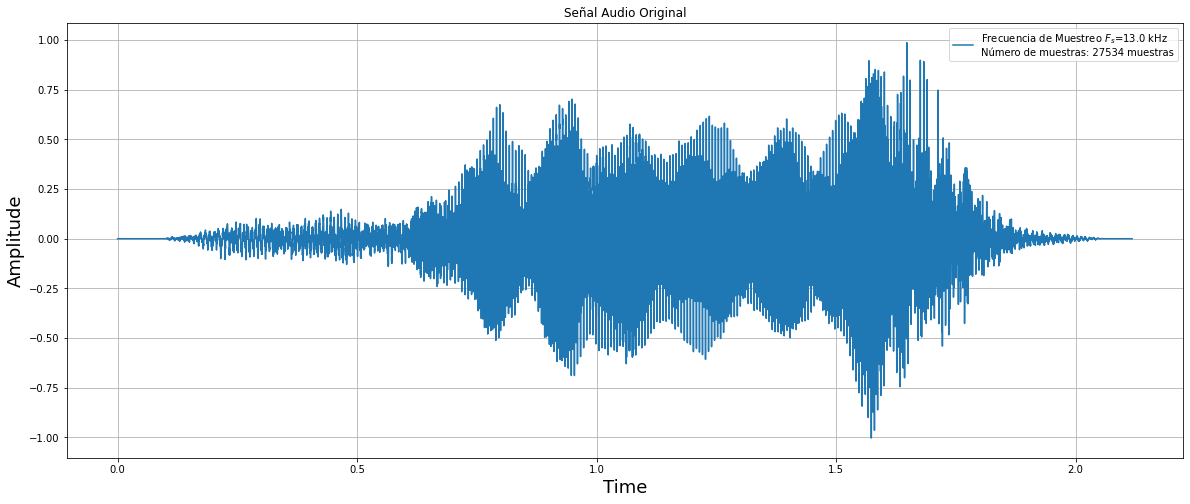

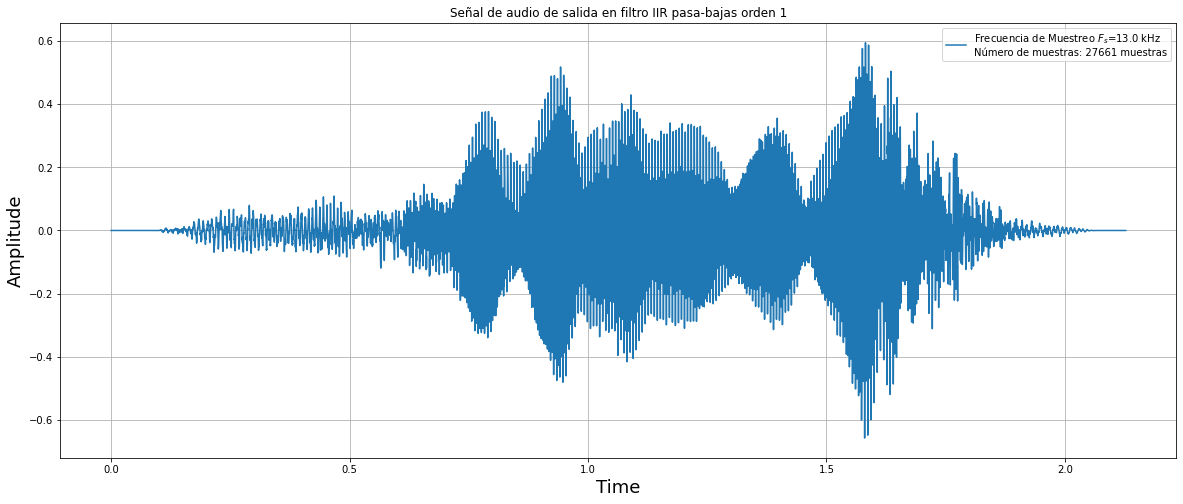

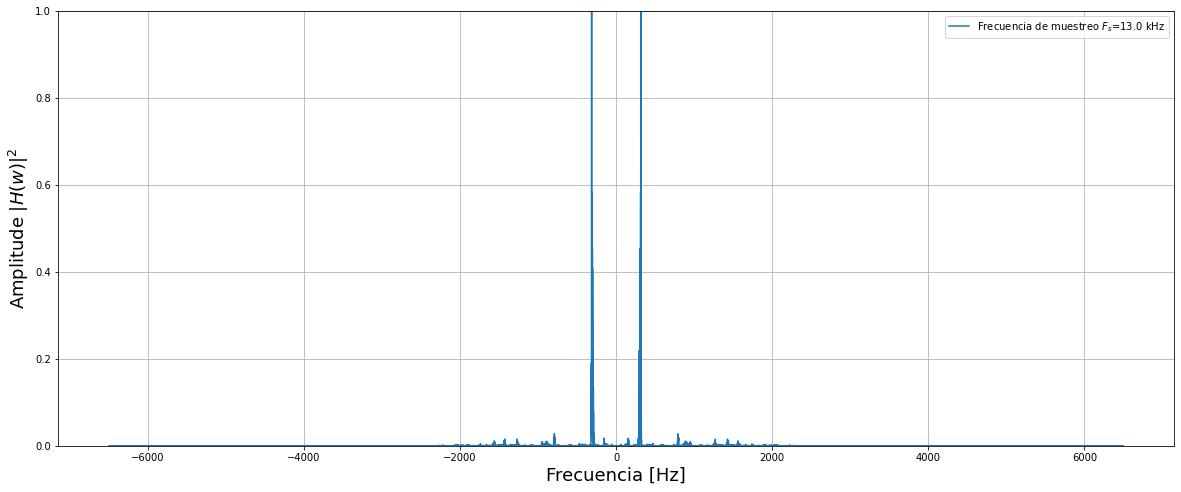

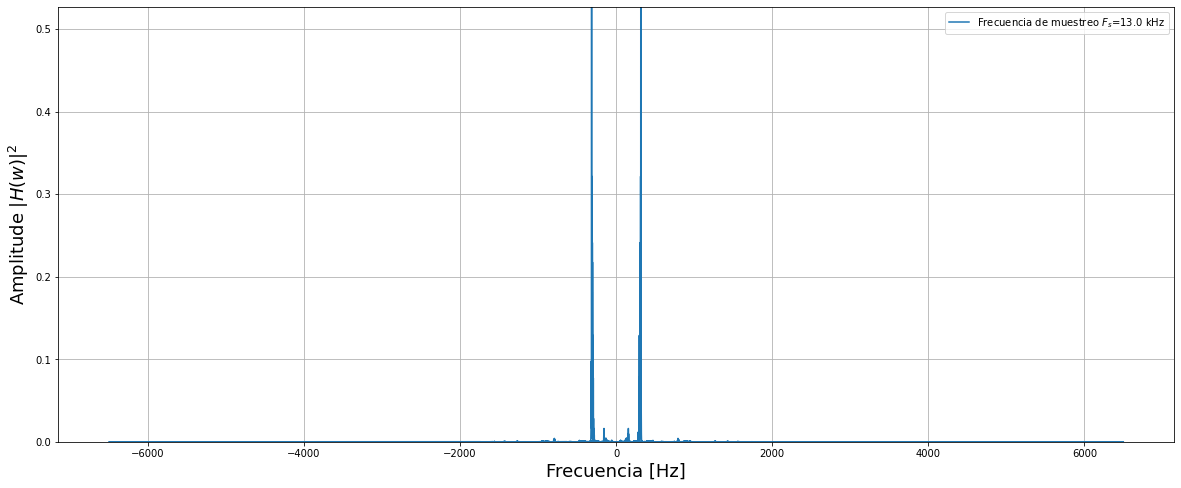


______________________________

Audio 1; Filename: audio1.wav


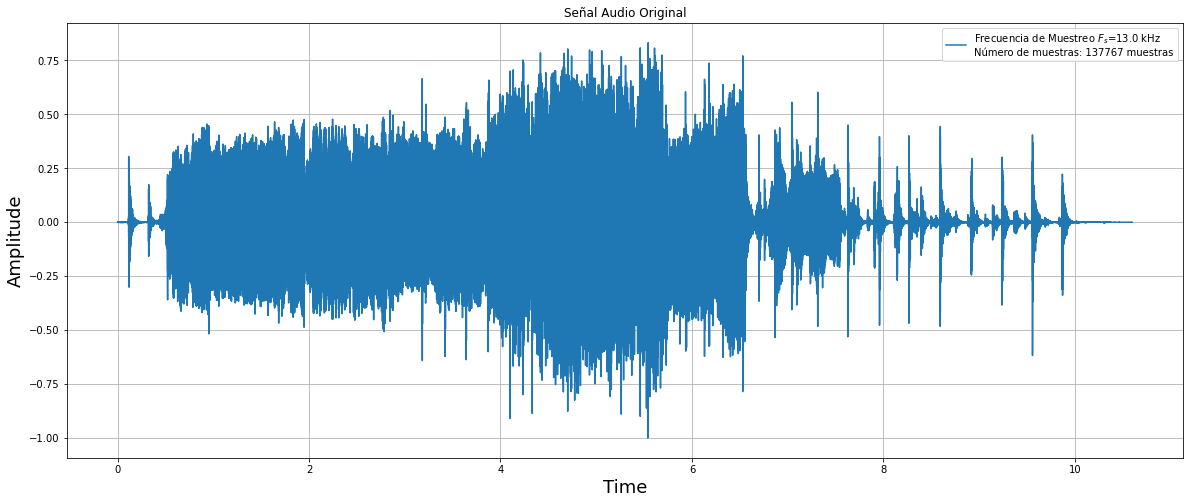

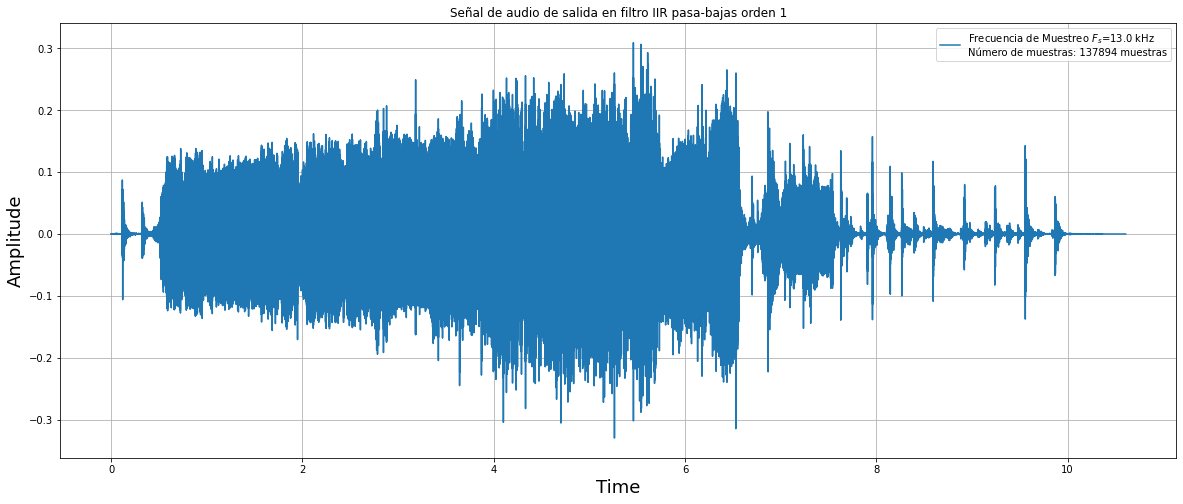

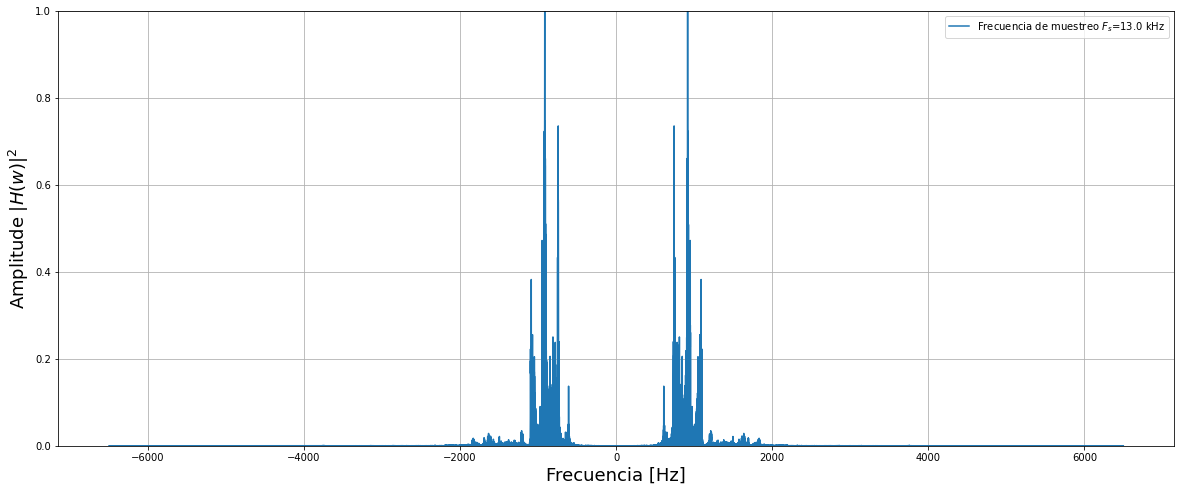

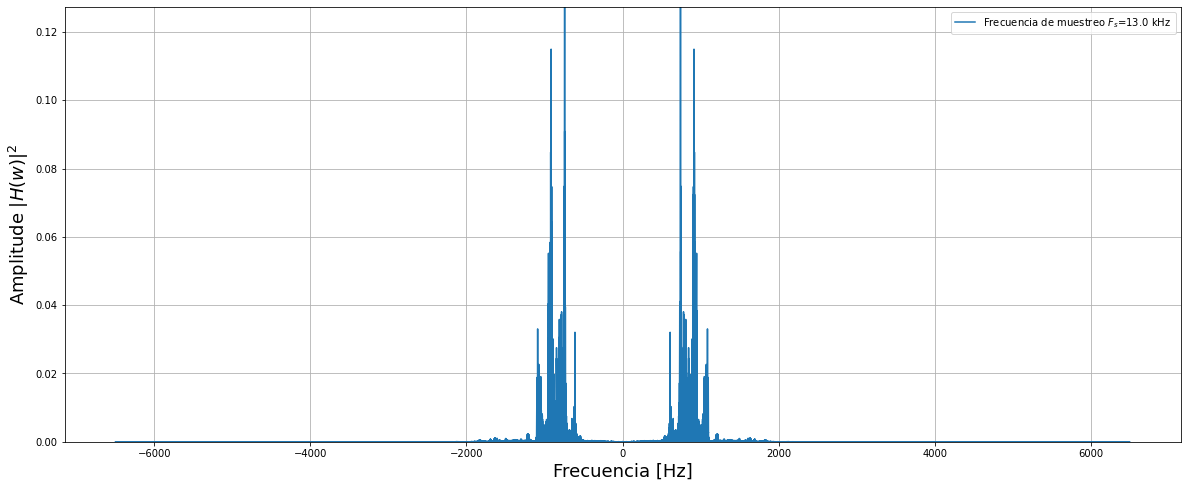


______________________________

Audio 2; Filename: audio2.wav


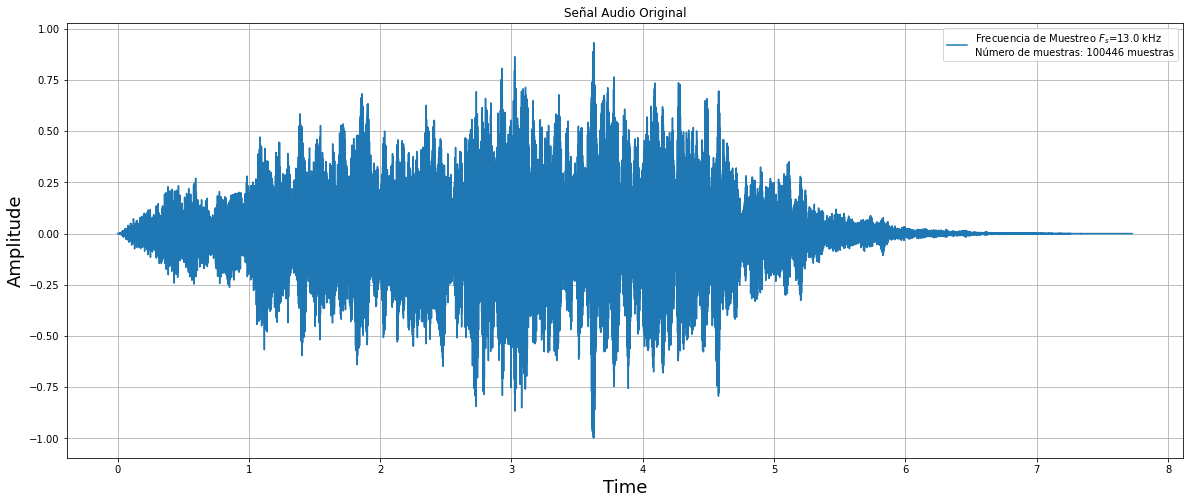

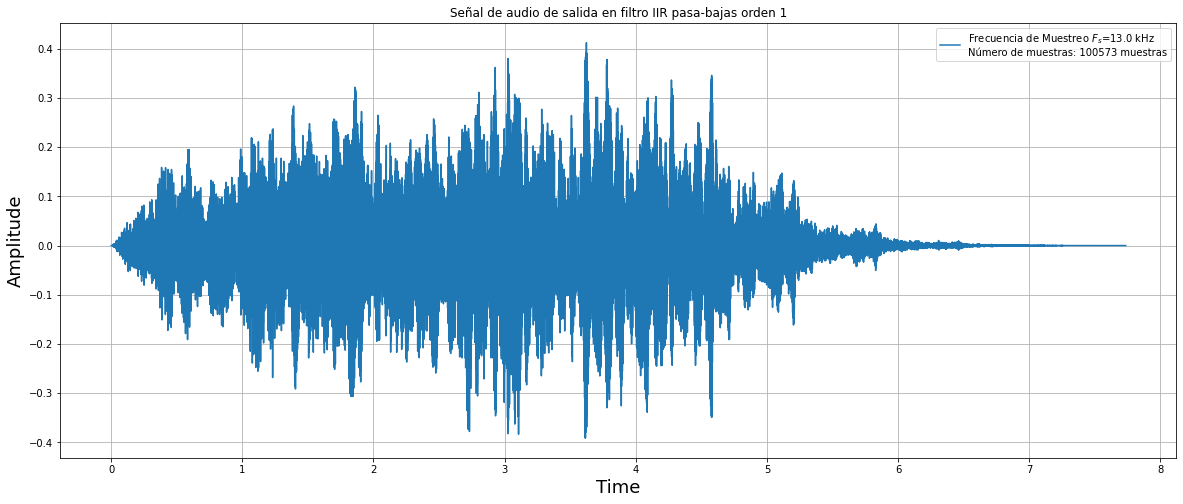

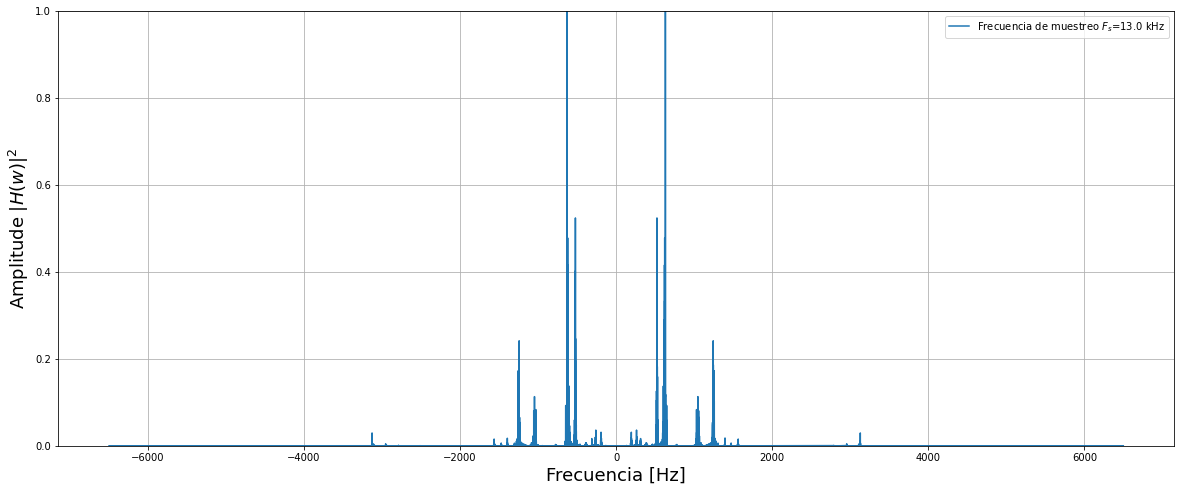

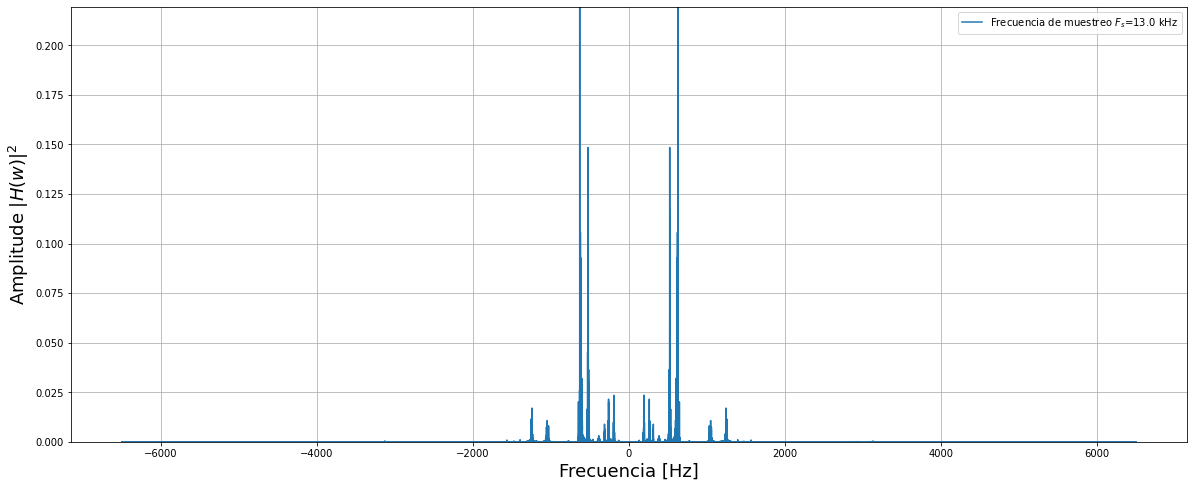

In [ ]:
#Reproduction song objects vector
push_songs=[]

def impz(b,a):
    l = Nfft
    impulse = repeat(0.,l); impulse[0] =1.
    x = np.arange(0,l)
    response = signal.lfilter(b,a,impulse)
    t = (1/fs)*x
    return t, response

t, hn = impz(b11,a11)


for i, filename in enumerate(filenames):
    print("\n______________________________\n")
    print("Audio %i; Filename:"%i, filename)
    push_songs.append(Audio(songs[i], rate=freq_songs[i]))
    
    y = np.convolve(hn,songs[i], mode="full")#Filtering de audio signal throught the designed filter.
    
    Y = np.fft.fft(y) #Getting frequency response of the filtered signal.
    freq_Y = np.fft.fftfreq(Y.size)*freq_songs[i]
    
    graph_audio(songs[i], freq_songs[i])
    display(push_songs[i])
    
    graph_audio(y, freq_songs[i], title = "Señal de audio de salida en filtro IIR pasa-bajas orden 1")
    display(Audio(y, rate=freq_songs[i]))
    
    lims = [max(abs(SONGS[i])**2),max(abs(Y)**2)]
    newrange = np.arange(0, len(freq_SONGS[i]), 1)
    plot_signal_spectrum(freq_SONGS[i], SONGS[i], freq_songs[i], lims, title ='')
    plot_signal_spectrum(freq_Y, Y, freq_songs[i], lims, zoom = True, title ='')

del (i)
del (filename)
del (y)
del (Y)
del (freq_Y)

Al comparar el espectro de la señal de entrada y salida en el dominio del tiempo resulta casi imperceptible sus cambios a menos que decidamos reproducir sus audios, donde podremos captar una señal más grave, o con mayor cantidad de energía en la zonas de baja frecuencia.

Ahora, si comparamos el efecto causado en el dominio de la frecuencia, se observa que efectivamente se han filtrado las componentes mayores a la frecuencia de corte del filtro diseñado, pero también se observa nuevamente atenuación como efecto indeseado para las zonas de la banda de paso (anteriores a la frecuencia de corte).

#### Conclusiones sobre filtros FIR e IIR

Como conclusión final, se pudo observar la facilidad en el diseño del filtro FIR a partir del diseño de su espectro en el dominio de la frecuencia y a través del uso de la transformada inversa (IDFT) para poder reconstruirla en el dominio del tiempo y así hallar los coeficientes.

Del mismo modo aplica para el caso del filtro IIR, en este caso resulta interesante la flexibilidad en el diseño que aporta el uso de la aproximación de derivadas que permite transformar un sistema complejo en otro más simple, que puede ser resuelto por métodos numéricos.

Dado que en el diseño del filtro IIR se podía observar un grado de libertad (Período T) que permitía asignar por iteración los requerimientos deseados por el filtro con respecto a la frecuencia de corte y el nivel de atenuación, lo cual nos permite seguir corroborando el hecho de que resulta más eficiente su implementación con respecto a un filtro FIR.

En otras palabras, si los requerimientos de diseño para un filtro FIR requieren que éste sea de un orden elevado (más complejo y costoso), será más óptimo en relación costo-beneficio implementar un filtro IIR el cual podrá cumplir los requerimientos de diseño iniciales, pero esta vez con un orden mucho menor (más simple y barato).